In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
#unzip the dataset folder
!unzip /content/drive/MyDrive/thesisproject/data.csv.zip

Archive:  /content/drive/MyDrive/thesisproject/data.csv.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data.csv                


# 1. Overview and understanding of data

## Load libraries

In [339]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import plotly.express as px

from random import sample
from numpy.random import uniform
from math import isnan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from matplotlib.ticker import PercentFormatter
%matplotlib inline

pd.set_option("display.max_rows", None,"display.max_columns", None)

warnings.simplefilter(action='ignore')
plt.style.use('seaborn')
sns.set_style("darkgrid")

## reading the dataset

In [482]:
# Importing data.csv
df = pd.read_csv('/content/data.csv', sep=",", encoding="unicode_escape", header=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## understanding the dataset

In [341]:
# basics of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## data preprocessing

### checking for null values

In [342]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [483]:
print("We have {} observations.".format(df.shape[0]))

df.dropna(inplace=True)

print("We have {} observations after removing null values.".format(df.shape[0]))

We have 541909 observations.
We have 406829 observations after removing null values.


Lets check invoiceNo!

In [344]:
df.InvoiceNo.head(10)

0    536365
1    536365
2    536365
3    536365
4    536365
5    536365
6    536365
7    536366
8    536366
9    536367
Name: InvoiceNo, dtype: object

InvoiceNo has coded with 6 digit numeric characters. Lets see if any InvoiceNo started with "C" character

In [345]:
df[df["InvoiceNo"].str.startswith("C")].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


We can see that, cancelled invoices have negative quantity.


In [484]:
df["Cancelled"] = df["InvoiceNo"].apply(lambda x: 1 if x.startswith("C") else 0)

In [485]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.Cancelled == 0]

print("We have {} observations after removing cancelled values.".format(df.shape[0]))

We have 406829 observations.
We have 397924 observations after removing cancelled values.


In [486]:
df["Description"] = df["Description"].str.lower()

In [349]:
df["UnitPrice"].describe()

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

*0* unit price?  lets check ! 



In [350]:
df[df.UnitPrice == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
9302,537197,22841,round cake tin vintage green,1,12/5/2010 14:02,0.0,12647.0,Germany,0
33576,539263,22580,advent calendar gingham sack,4,12/16/2010 14:36,0.0,16560.0,United Kingdom,0
40089,539722,22423,regency cakestand 3 tier,10,12/21/2010 13:45,0.0,14911.0,EIRE,0
47068,540372,22090,paper bunting retrospot,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0
47070,540372,22553,plasters in tin skulls,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0


Uniprice can't be 0. So I should remove theme

In [487]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.UnitPrice > 0]

print("We have {} observations after removing records that have 0 unit price.".format(df.shape[0]))

We have 397924 observations.
We have 397884 observations after removing records that have 0 unit price.


In [488]:
print("Lower limit for UnitPrice: " + str(np.exp(-2)))
print("Upper limit for UnitPrice: " + str(np.exp(3)))

Lower limit for UnitPrice: 0.1353352832366127
Upper limit for UnitPrice: 20.085536923187668


so we can remove the rows with less than 0.1 unitprice



In [489]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.UnitPrice > 0.1)]

print("We have {} observations after removing unit prices smaller than 0.1.".format(df.shape[0]))

We have 397884 observations.
We have 397585 observations after removing unit prices smaller than 0.1.


In [354]:
df["Quantity"].describe()

count    397585.000000
mean         12.903495
std         179.208530
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [355]:
Most_quantity=df.sort_values(by='Quantity', ascending=False)
Most_quantity.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
540421,581483,23843,"paper craft , little birdie",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom,0
61619,541431,23166,medium ceramic top storage jar,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,0
421632,573008,84077,world war 2 gliders asstd designs,4800,10/27/2011 12:26,0.21,12901.0,United Kingdom,0
206121,554868,22197,small popcorn holder,4300,5/27/2011 10:52,0.72,13135.0,United Kingdom,0
97432,544612,22053,empire design rosette,3906,2/22/2011 10:43,0.82,18087.0,United Kingdom,0


In [356]:
np.quantile(df.Quantity, 0.9999)

1490.8992000001017

In [490]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.Quantity < 1490)]

print("We have {} observations after removing quantities greater than 150.".format(df.shape[0]))

We have 397585 observations.
We have 397545 observations after removing quantities greater than 150.


## making additional columns

In [491]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [492]:
df.drop("Cancelled", axis = 1, inplace = True)

In [360]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


### Saving the modified dataset

In [493]:
df.to_csv("/content/drive/MyDrive/thesisproject/customerData.csv", index = False)

In [494]:
!cp "/content/drive/MyDrive/thesisproject/customerData.csv" newData.csv

### Working with new modified dataset

In [495]:
df = pd.read_csv('/content/newData.csv', sep=",", encoding="unicode_escape", header=0)

In [364]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


# Exploratory data analysis

In [496]:
#What products are the top 5 in sales? 
Top_products=df[['StockCode','Description','Quantity','TotalPrice']].groupby(['StockCode','Description'],as_index=False).sum(['Quantity','TotalPrice']).sort_values(by='Quantity',ascending=False)
#WE have to exclude the rows with no stockcode
Top_products=Top_products[Top_products['StockCode'].str.contains('^[1-9]')]
Top_products.head()

,StockCode,Description,Quantity,TotalPrice
3441,85099B,jumbo bag red retrospot,46181,85220.78
3017,84077,world war 2 gliders asstd designs,42415,11152.65
430,21212,pack of 72 retrospot cake cases,33693,16394.53
3456,85123A,white hanging heart t-light holder,32865,90894.65
3275,84879,assorted colour bird ornament,32482,52404.34


In [497]:
#Let´s see the top 5 in revenue, let's exclude 
Top_revenue=Top_products.sort_values(by='TotalPrice', ascending=False)
Top_revenue.head(5)

,StockCode,Description,Quantity,TotalPrice
1316,22423,regency cakestand 3 tier,12402,142592.95
3456,85123A,white hanging heart t-light holder,32865,90894.65
3441,85099B,jumbo bag red retrospot,46181,85220.78
2796,47566,party bunting,15291,68844.33
3275,84879,assorted colour bird ornament,32482,52404.34


Text(0.5, 1.0, 'Top 5 products in revenue')

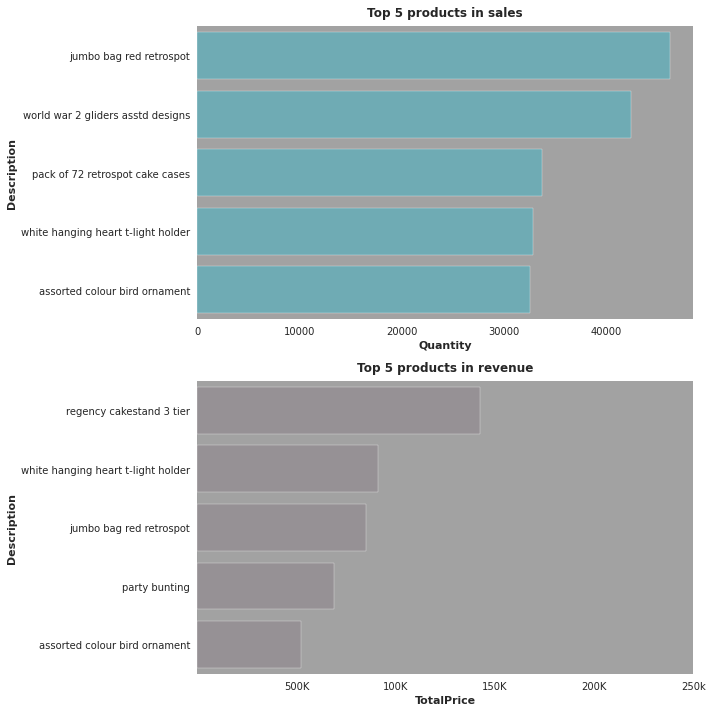

In [498]:
f, axis=plt.subplots(2,1,figsize=(10,10))
ax2=sns.barplot(x='Quantity', y='Description', data=Top_products.head(5), color='#63b3c0',ax=axis[0]).set(title='Top 5 products in sales')
ax3=sns.barplot(x='TotalPrice',y='Description', data=Top_revenue.head(5), color='#979095',ax=axis[1])
ax3.set_xticks([50000, 100000, 150000, 200000,250000])
ax3.set_xticklabels(['500K','100K','150K','200K','250k'])
plt.title('Top 5 products in revenue')

In [499]:
#What was the total revenue?
Sum_revenue=df.TotalPrice.sum()
print ('Total Revenue:\n','$ ', round(Sum_revenue,2))

Total Revenue:
 $  8581133.86


## Lets check about our customers

In [369]:
df.CustomerID.value_counts()

17841.0    7845
14911.0    5665
14096.0    5111
12748.0    4583
14606.0    2700
15311.0    2379
14646.0    2074
13089.0    1818
13263.0    1677
14298.0    1627
15039.0    1502
14156.0    1399
18118.0    1279
14159.0    1204
14796.0    1141
16033.0    1137
15005.0    1119
14056.0    1106
14769.0    1090
13081.0    1023
16549.0     980
14527.0     972
14456.0     967
17511.0     957
15719.0     937
16931.0     897
15555.0     897
17811.0     851
14505.0     799
18283.0     756
17338.0     753
17757.0     741
12921.0     720
12415.0     714
16904.0     710
15159.0     707
16764.0     706
17675.0     705
13137.0     704
15547.0     702
17920.0     696
17735.0     690
16923.0     672
15529.0     672
16360.0     662
16241.0     662
16729.0     660
15856.0     645
12681.0     638
13969.0     626
14502.0     624
16713.0     624
13230.0     611
14415.0     590
14088.0     589
16686.0     585
14194.0     579
17611.0     576
14667.0     573
13098.0     571
17238.0     566
13694.0     564
15023.0 

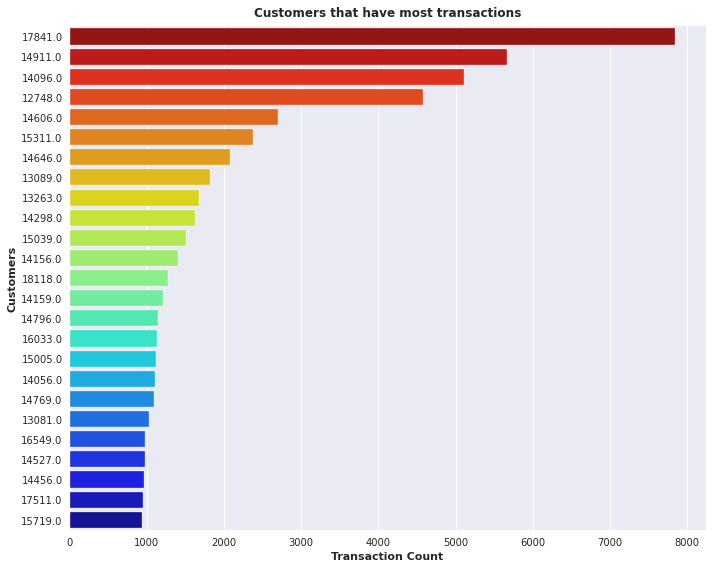

In [370]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).head(25)
fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h", 
            ax = ax, order = customer_counts.index, palette = "jet_r")
plt.title("Customers that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")
plt.show()

### Lets check about countries

In [371]:
df.Country.value_counts()

United Kingdom          354015
Germany                   9028
France                    8338
EIRE                      7225
Spain                     2484
Netherlands               2357
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1069
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      320
Israel                     247
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     150
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

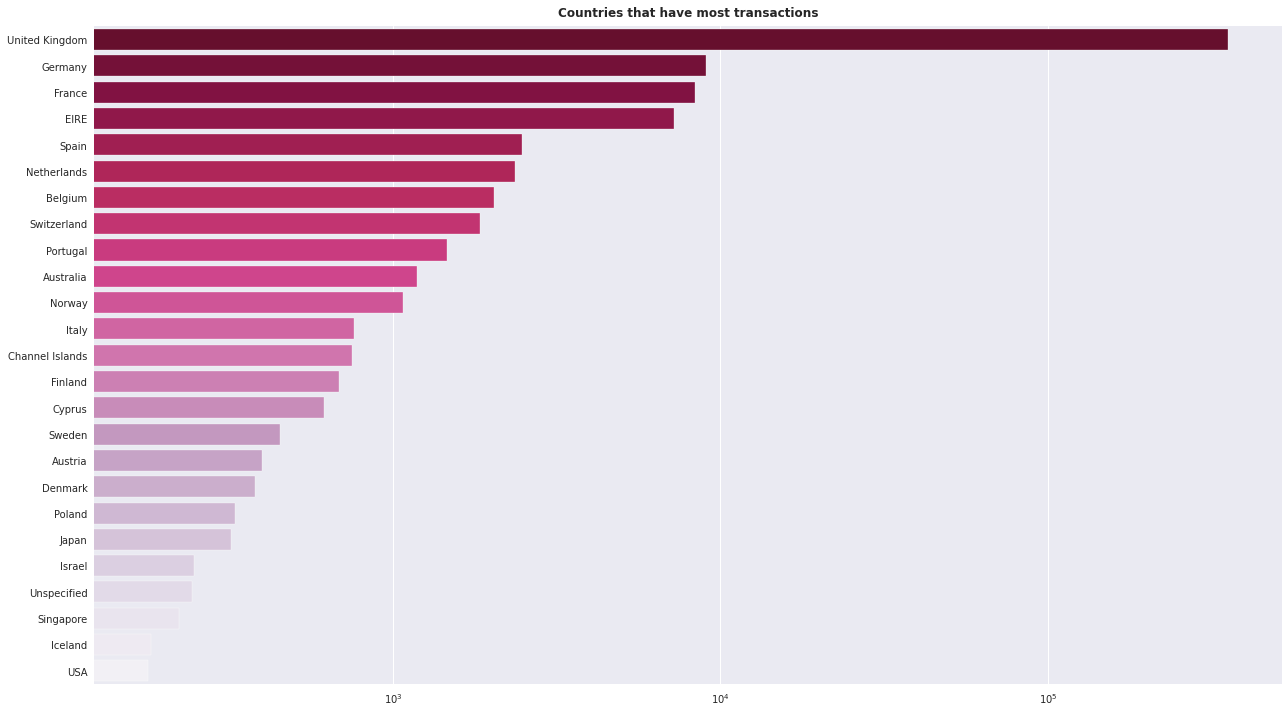

In [372]:
country_counts = df.Country.value_counts().sort_values(ascending=False).head(25)
fig, ax = plt.subplots(figsize = (18, 10))
sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h", 
            ax = ax, order = country_counts.index, palette = "PuRd_r")
plt.title("Countries that have most transactions")
plt.xscale("log")
plt.show()

### Lets check about product quantity

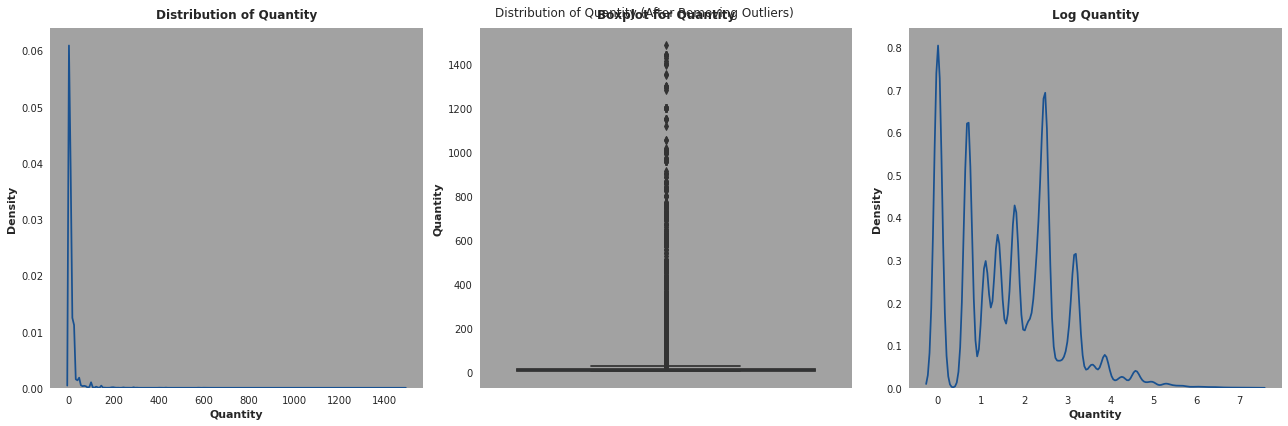

In [500]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))
sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")
fig.suptitle("Distribution of Quantity (After Removing Outliers)")
plt.show()

In [501]:
df['InvoiceDate2'] = df['InvoiceDate'] # For further eda we need this
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.InvoiceDate.head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

#2. Cohort Analysis

Cohort analysis is a subset of behavioral analytics that takes the data from a given eCommerce platform, web application, or online game and rather than looking at all users as one unit, it breaks them into related groups for analysis.
Generally, we have three type of cohort analysis:

- Time cohorts or Acquisition cohorts: Groups are divided by first activity.
- Behavior cohorts or Segment-Based cohorts: Groups are divided by their behaivors and actions about your service.
- Size cohorts: Size-based cohorts refer to the various sizes of customers who purchase a company’s products or services.

In [502]:
df_c=df.copy()
df_c.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDate2
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12/1/2010 8:26
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12/1/2010 8:26
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26


In [503]:
df_c.drop('InvoiceDate2', axis=1, inplace=True)

In [504]:
import datetime as dt

In [505]:
print("Min date: {} \nMax date: {}".format(df_c.InvoiceDate.min(), df_c.InvoiceDate.max()))
print("Time difference is: {}".format(df_c.InvoiceDate.max() - df_c.InvoiceDate.min()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00
Time difference is: 373 days 04:24:00


In [506]:
def get_month(x): return dt.datetime(x.year, x.month, 1) 
def get_dates(df_c, col):
    year = df_c[col].dt.year
    month = df_c[col].dt.month
    day = df_c[col].dt.day
    return year, month, day

In [507]:
df_c["InvoiceMonth"] = df_c["InvoiceDate"].apply(get_month)
df_c["CohortMonth"] = df_c.groupby("CustomerID")["InvoiceMonth"].transform("min")

In [508]:
df_c.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01


In [509]:
invoice_year, invoice_month, invoice_day = get_dates(df_c, "InvoiceMonth")
cohort_year, cohort_month, cohort_day = get_dates(df_c, "CohortMonth")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df_c["CohortIndex"] = 12 * year_diff + month_diff + 1

In [510]:
cohort_data = df_c.groupby(["CohortIndex", "CohortMonth"])["CustomerID"].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index = "CohortMonth", columns = "CohortIndex", values = "CustomerID")
cohort_pivot

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,884.0,324.0,286.0,340.0,321.0,352.0,321.0,308.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,416.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,378.0,71.0,71.0,108.0,102.0,93.0,96.0,104.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,113.0,90.0,101.0,75.0,120.0,104.0,125.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,283.0,54.0,49.0,49.0,59.0,66.0,75.0,26.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,243.0,42.0,38.0,65.0,56.0,80.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,189.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Above data is our cohort table. Its interpretation is simple. For example, We have 884 unique customer with their first transaction is in 2010-12. Its cohort month is 2010-12 and cohort index is 1. Go on the one right cell, it is 324. Its mean, 324 unique customer retain their customership for next month.

In [511]:
cohort_sizes = cohort_pivot.iloc[:, 0]

In [512]:
customer_per_month = df_c.groupby("CohortMonth")["CustomerID"].nunique().values
customers = customer_per_month.cumsum()
customers = customers[::-1]
customers

array([4336, 4295, 3972, 3614, 3314, 3145, 2956, 2713, 2430, 2130, 1678,
       1300,  884])

In [513]:
customer_in_month = df_c.groupby("CohortIndex")["CustomerID"].nunique()
customer_in_month

CohortIndex
1     4336
2      975
3      941
4      928
5      904
6      875
7      803
8      721
9      679
10     641
11     509
12     494
13     235
Name: CustomerID, dtype: int64

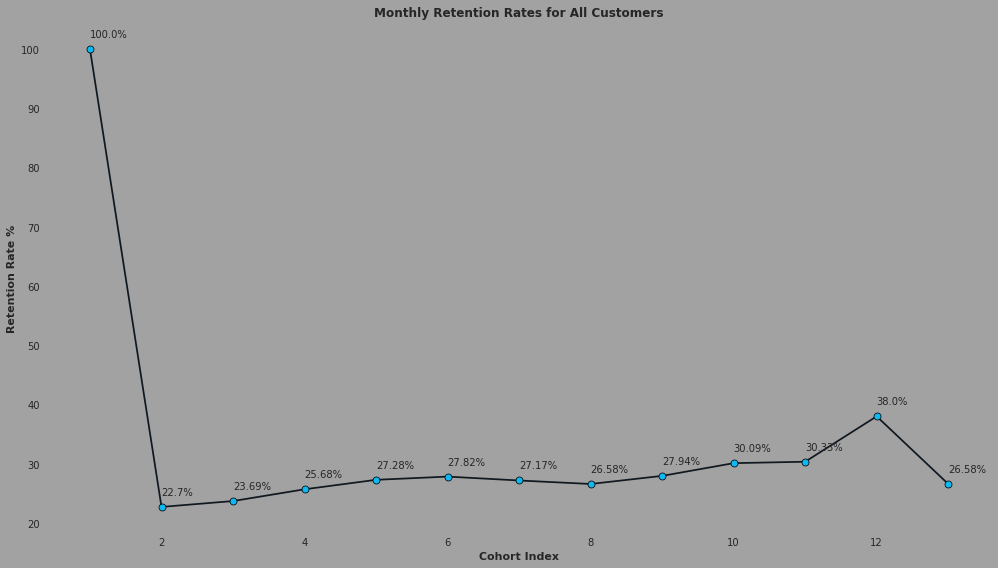

In [514]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (14, 8), facecolor = "#A2A2A2")
ax.grid(False)
x = customer_in_month.index
y = 100*(customer_in_month / customers)

sns.lineplot(x = x, y = y,  color = "#101820", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

for x, y in zip(x, y):
    plt.text(x, y + 2, s = str(round(y, 2)) + "%")

plt.xlabel("Cohort Index")
plt.ylabel("Retention Rate %")
plt.title("Monthly Retention Rates for All Customers")
sns.despine()
plt.show()

Great!

We can see that Retention rate increases significantly for last months of the year.

In [515]:
monthly_customer_price_df = df_c.groupby("InvoiceMonth").agg({"TotalPrice": "sum",
                                                            "CustomerID": "nunique"})
monthly_customer_price_df

,TotalPrice,CustomerID
InvoiceMonth,,
2010-12-01,568520.33,884
2011-01-01,477089.74,740
2011-02-01,440490.11,756
2011-03-01,594950.34,974
2011-04-01,454231.78,856
2011-05-01,673713.22,1054
2011-06-01,659942.42,991
2011-07-01,599638.47,948
2011-08-01,639005.82,934


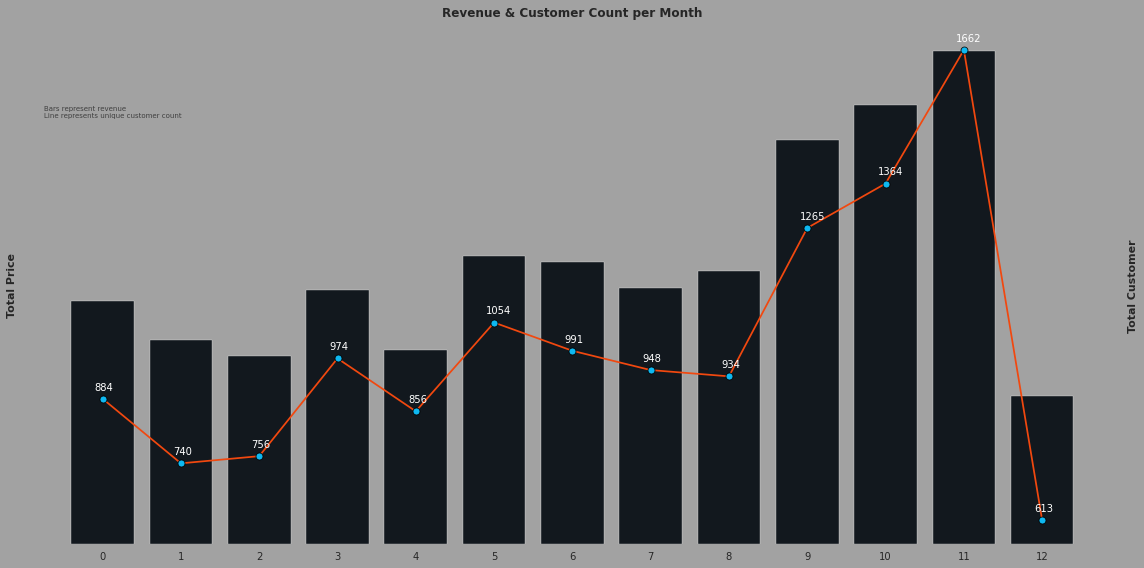

In [516]:
fig, ax = plt.subplots(figsize = (16, 8), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.barplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.TotalPrice, ax = ax,
            color = "#101820")
ax2 = ax.twinx()
sns.lineplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.CustomerID, ax = ax2,
            color = "#F1480F", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylabel("Total Customer", fontname = "DejaVu Sans")
ax.set_ylabel("Total Price", fontname = "DejaVu Sans")
plt.title("Revenue & Customer Count per Month", fontname = "DejaVu Sans")
ax.text(-0.75, 1000000, "Bars represent revenue \nLine represents unique customer count", 
        fontsize = 7, alpha = 0.8, fontname = "DejaVu Sans")
for x, y in zip(np.arange(len(monthly_customer_price_df.index)),  monthly_customer_price_df.CustomerID):
    ax2.text(x -0.1, y + 20 , y, color = "white")
    
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

## Pareto Principle

*  The Pareto principle states that for many outcomes, roughly 80% of consequences come from 20% of causes (the “vital few”).

Other names for this principle are the 80/20 rule, the law of the vital few, or the principle of factor sparsity.
* Lets implement Pareto's 80-20 rule to our dataset. We have two hypothesis:
    - 1) 80% of company's revenue comes from 20% of total customers.

    - 2) 80% of company's revenue comes from 20% of total products.

To check these hypothesis, we need only two things.

- 1) Individual sale records for customer/product

- 2) Calculating cumulative sum for them

I define below functions for calculation and visualization.

* prepare_pareto_data finds individual revenue per customer/product and calculates cumulative percentage of them.

* create_pareto_plot takes output from these data and visualize it.

In [517]:
def prepare_pareto_data(df_c, col, price):
    
    df_c_price = pd.DataFrame(df_c.groupby(col)[price].sum())
    df_c_price = df_c_price.sort_values(price, ascending = False)

    df_c_price["CumulativePercentage"] = (df_c_price[price].cumsum() / df_c_price[price].sum() * 100).round(2)
    
    return df_c_price

In [521]:
def create_pareto_plot(df_c, col, price, log = True):
    
    plt.rcParams["axes.facecolor"] = "#A2A2A2"
    fig, ax = plt.subplots(figsize = (15, 5), dpi = 150, facecolor = "#A2A2A2")
    plt.rcParams["axes.grid"] = False
    
    if log == True:
        sns.barplot(x = np.arange(len(df_c)), y = np.log(df_c[price]),  ax = ax, color = "#101820")
        ax.set_ylabel("Total Price (Log - Scale)")
    else:
        sns.barplot(x = np.arange(len(df_c)), y = df_c[price],  ax = ax, color = "#101820")

    ax2 = ax.twinx()
    
    sns.lineplot(x = np.arange(len(df_c)), y = df_c.CumulativePercentage, ax = ax2, color = "#0019AA")
    ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1)
    ax2.axhline(90, color = "#008878", linestyle = "dashed", alpha = 0.75)

    vlines = [int(len(df_c) * x / 10) for x in range(1, 10)]
    for vline in vlines: ax2.axvline(vline, color = "#008878", linestyle = "dashed", alpha = 0.1)
        
    interaction_80 = (df_c.shape[0] - df_c[df_c.CumulativePercentage >= 80].shape[0])
    ax2.axvline(interaction_80, color = "#008878", linestyle = "dashed", alpha = 1)

    interaction_80_percentage = round((interaction_80 / df_c.shape[0]) * 100)
    plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")   
    
    prop = dict(arrowstyle= "-|>", color = "#000000", lw = 1.5, ls = "--")
    plt.annotate("", xy = (interaction_80 - 10, 80),  xytext = (interaction_80 + 120 , 73), arrowprops = prop)
    
    interaction_90 = (df_c.shape[0] - df_c[df_c.CumulativePercentage >= 90].shape[0])
    ax2.axvline(interaction_90, color = "#008878", linestyle = "dashed", alpha = 0.8)
    interaction_90_percentage = round((interaction_90 / df_c.shape[0]) * 100)
    plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")   
    plt.annotate("", xy = (interaction_90 - 10, 90),  xytext = (interaction_90 + 120 , 83), arrowprops = prop)

    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.set_yticks([])
    plt.xticks([])
    ax.set_ylabel("Revenue", fontname = "DejaVu Sans")
    ax2.set_ylabel("Cumulative Percentage", fontname = "DejaVu Sans")
    subject = "Customers" if col == "CustomerID" else "Products"
    plt.title("Pareto Chart for " + subject, fontname = "DejaVu Sans")
    ax.set_xlabel(subject, fontname = "DejaVu Sans")
    sns.despine(left = True, right = True, bottom = True, top = True)
    plt.show()

### Pareto Chart for Customers

In [519]:
customer_price = prepare_pareto_data(df_c, "CustomerID", "TotalPrice")
customer_price.head(10)

,TotalPrice,CumulativePercentage
CustomerID,,
14646.0,273969.86,3.19
18102.0,259657.30,6.22
17450.0,188323.51,8.41
14911.0,143784.64,10.09
12415.0,124914.53,11.54
14156.0,117375.63,12.91
17511.0,90831.98,13.97
16029.0,76512.84,14.86
16684.0,66653.56,15.64


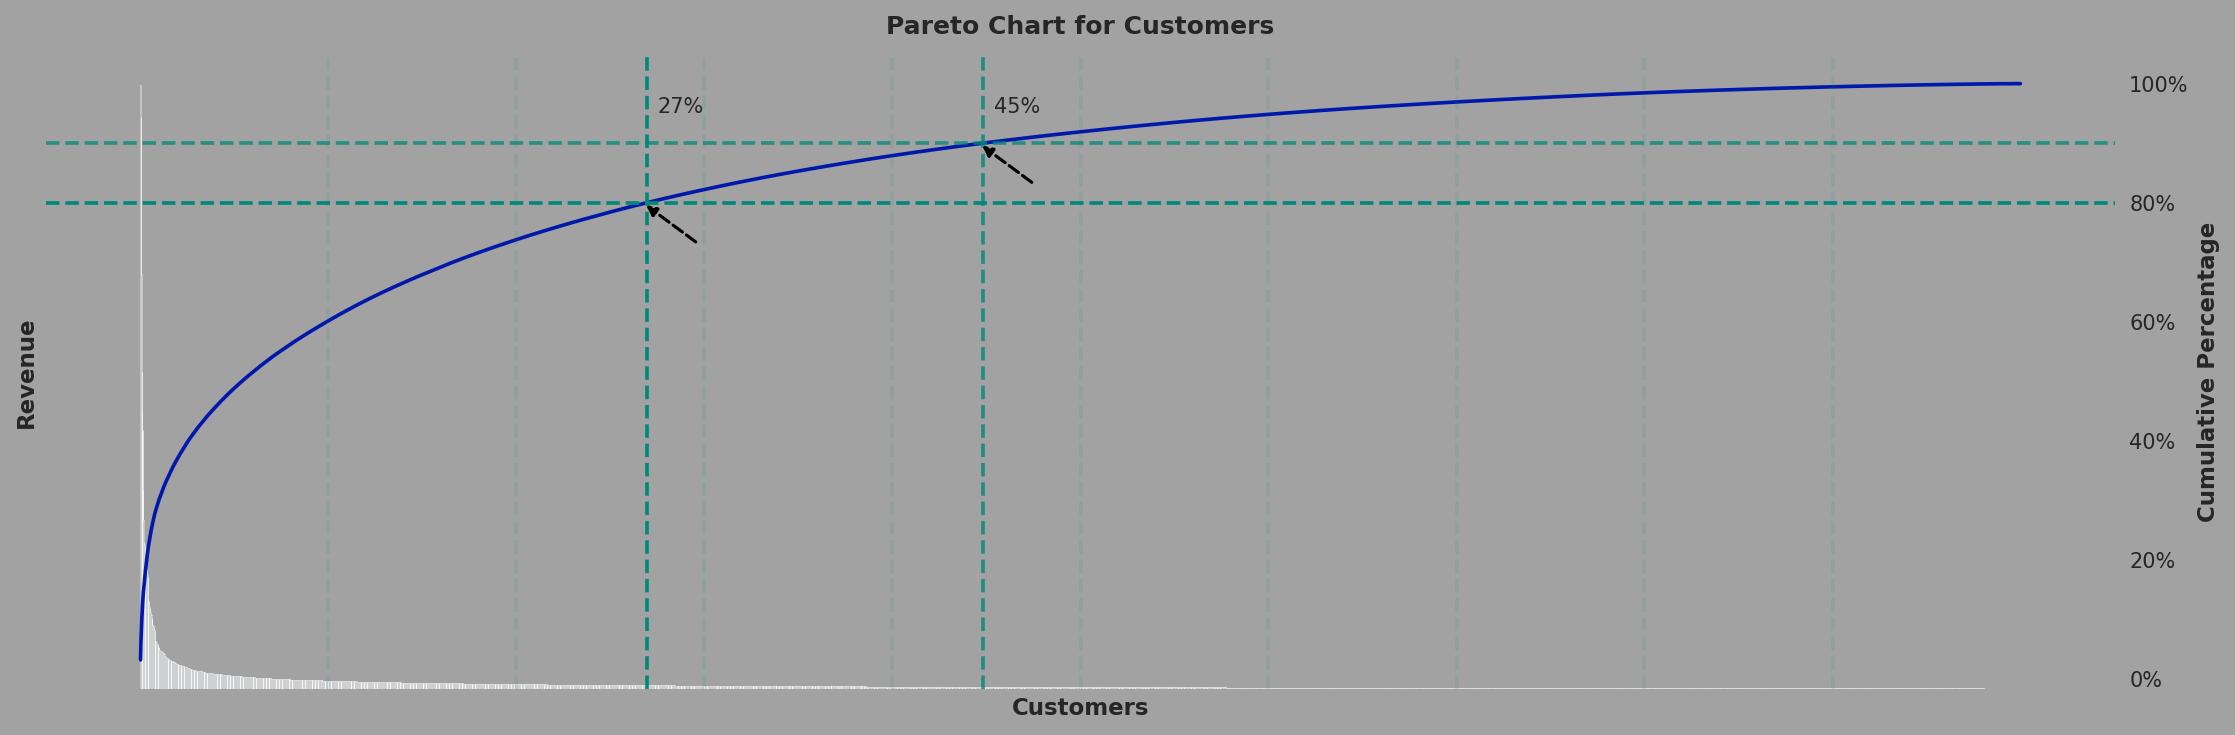

In [522]:
create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = False)

We can also plot it in log scale. It helps us for better visualization.



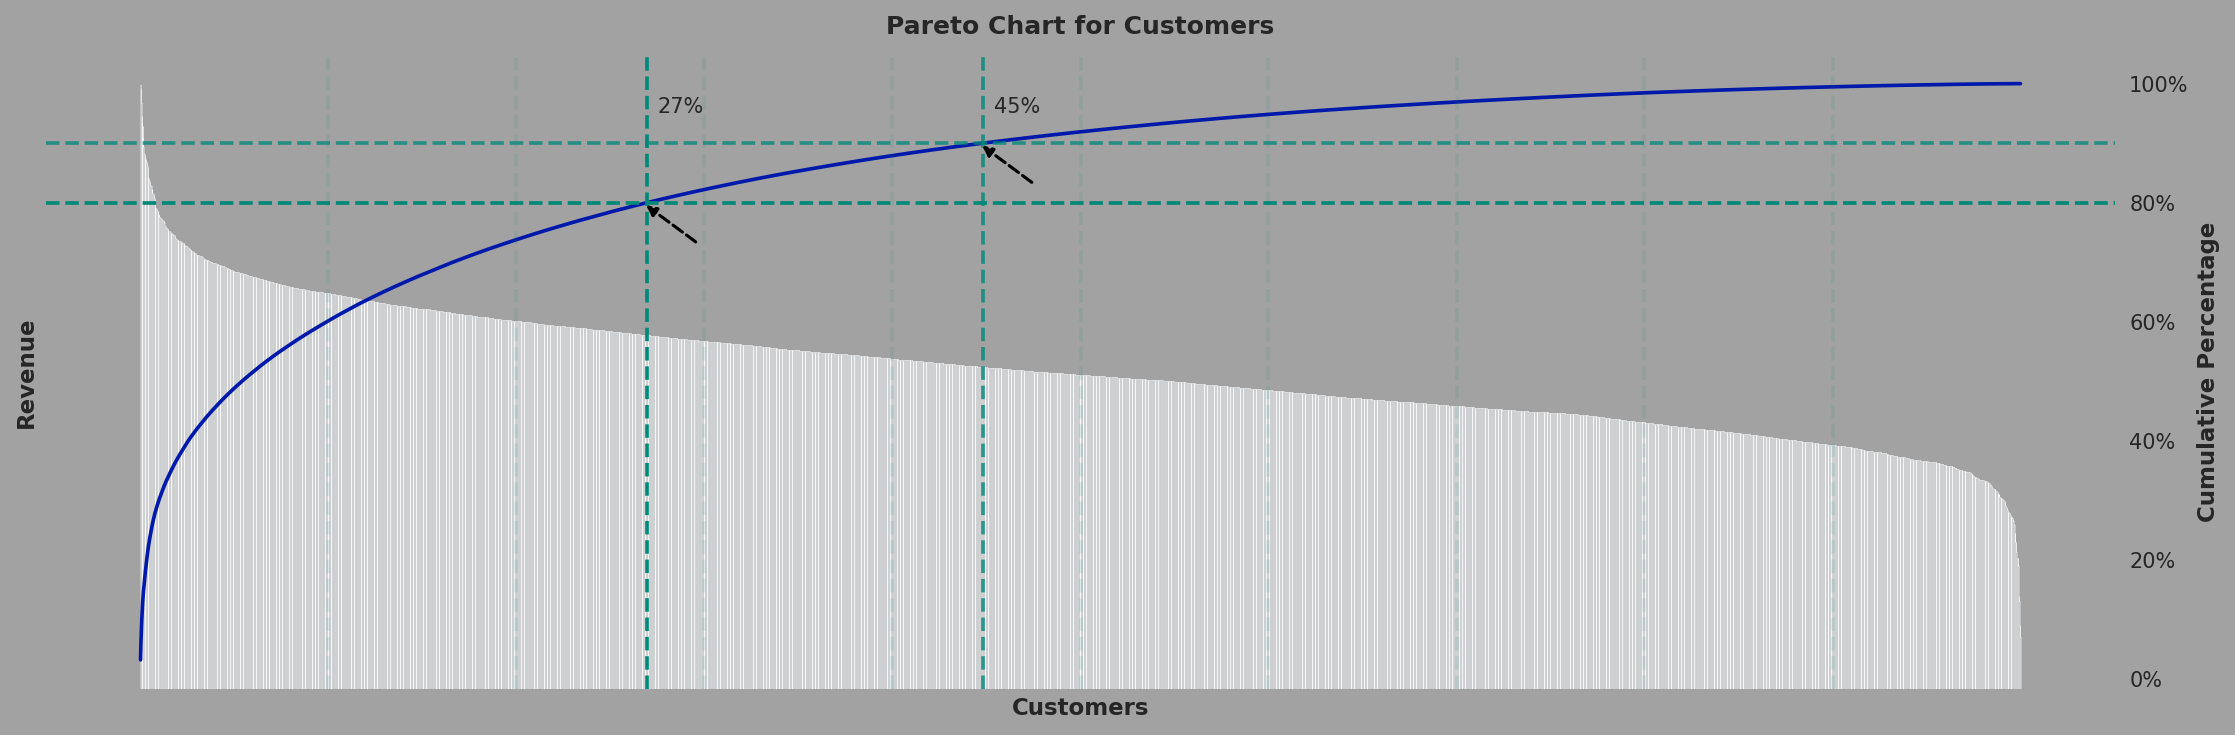

In [523]:
create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = True)

Well, lets interpret these two charts. Actually, we don't need to write a lot of things.

We can see that 80% of company's revenue comes from top 27% of customers.

Also, 90% of company's revenue comes from top 45% of customers

### Pareto Chart for Products

In [524]:
item_price = prepare_pareto_data(df_c, "StockCode", "TotalPrice")

item_price.head(10)

,TotalPrice,CumulativePercentage
StockCode,,
22423,142592.95,1.66
85123A,91050.00,2.72
85099B,85220.78,3.72
POST,77803.96,4.62
47566,68844.33,5.42
M,53346.55,6.05
84879,52404.34,6.66
22502,47366.20,7.21
79321,46286.51,7.75


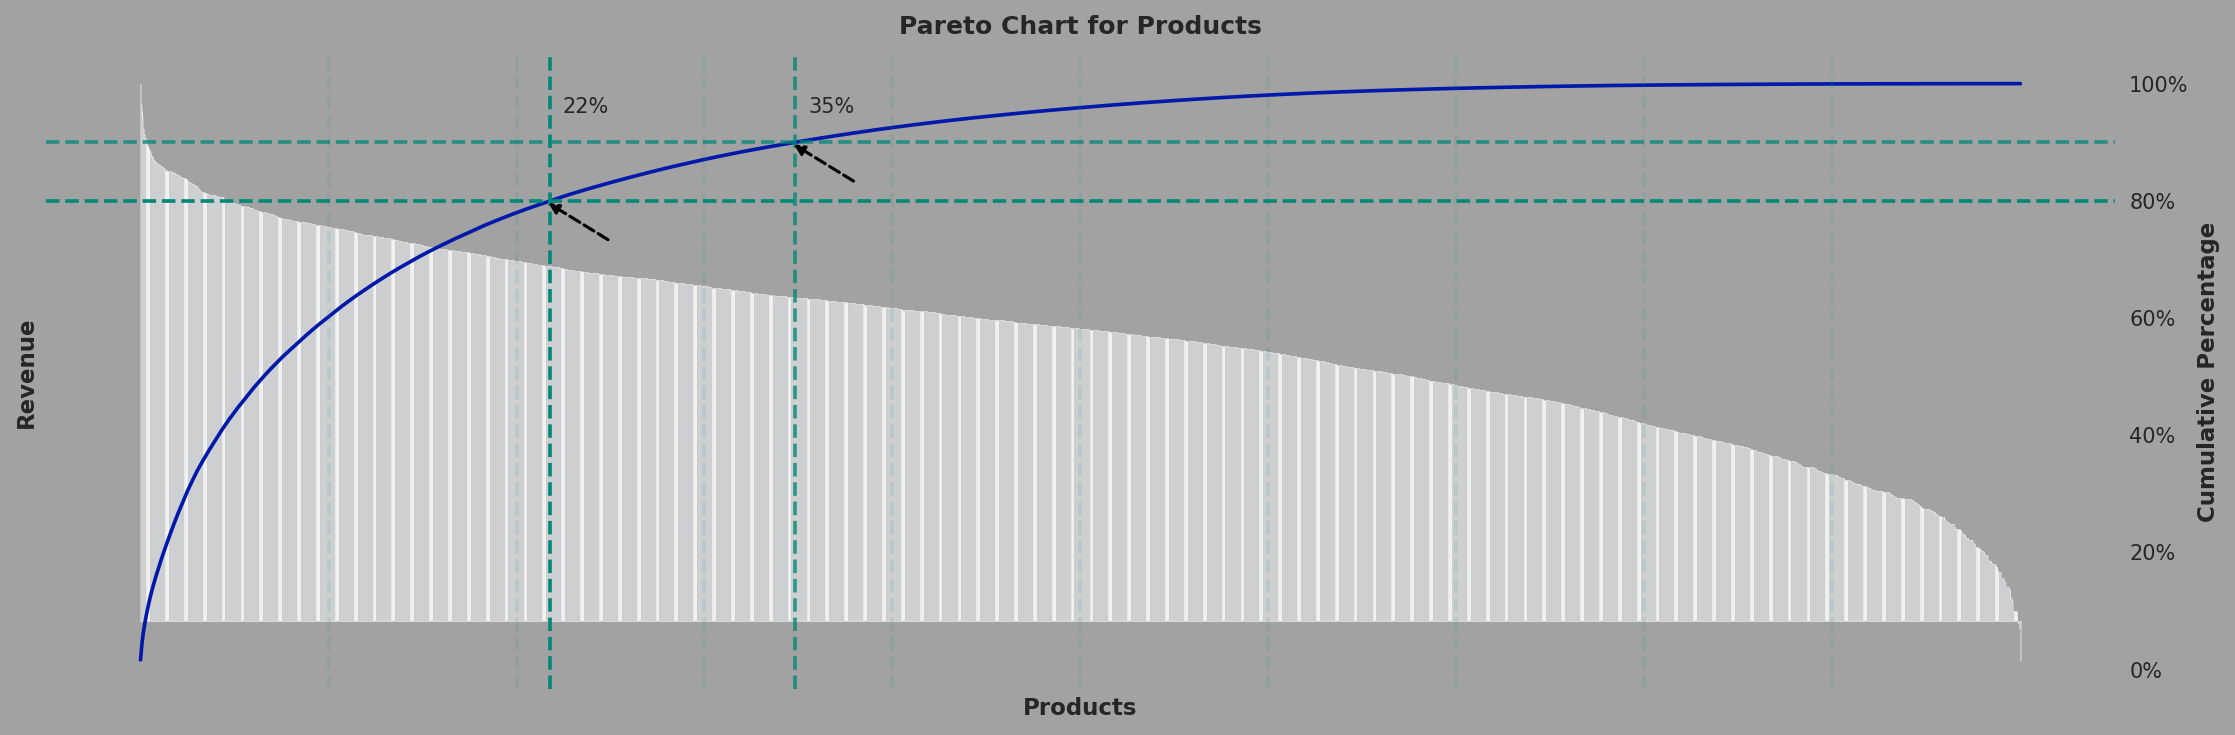

In [525]:
create_pareto_plot(item_price, "StockCode", "TotalPrice", log = True)

We can see that 80% of company's revenue comes from top 22% of products that have most revenue.

Also, 90% of company's revenue comes from 35% of products that have most revenue.

Maybe, if the company reduce by half its variety of items, revenue couldn't decrease significantly.

In [526]:
top_customers = customer_price[customer_price.CumulativePercentage <= 80].index.tolist()

products_for_top_customers = df_c[df_c.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()

products_for_other_customers = df_c[~df_c.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()

In [527]:
print(len(top_customers),len(products_for_top_customers),len(products_for_other_customers))

1169 3729 3643


In [528]:
data_summary = {'Top Customers': top_customers, 'Products For Top Custoemrs': products_for_top_customers,'Products For others customers': products_for_other_customers}
df_s = pd.DataFrame.from_dict(data_summary, orient='index')
df_s = df_s.transpose()

In [529]:
df_s.head()

,Top Customers,Products For Top Custoemrs,Products For others customers
0,14646,white hanging heart t-light holder,paper chain kit 50's christmas
1,18102,white metal lantern,victorian sewing box large
2,17450,cream cupid hearts coat hanger,wood black board ant white finish
3,14911,knitted union flag hot water bottle,colour glass t-light holder hanging
4,12415,red woolly hottie white heart.,hanging metal heart lantern


In [530]:
df_s.to_csv("/content/drive/MyDrive/thesisproject/Data_Cohort_Sum.csv", index = False)

In [531]:
!cp "/content/drive/MyDrive/thesisproject/Data_Cohort_Sum.csv" dataFromCohortSum.csv

# 3. RFM Analysis

Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. The RFM model is based on three quantitative factors:

Recency: How recently a customer has made a purchase

Frequency: How often a customer makes a purchase

Monetary Value: How much money a customer spends on purchases

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.

Let's perform RFM Analysis on our data.




## Preparing RFM Table

In [532]:
df_rfm = df.copy()
df_rfm.drop('InvoiceDate2', axis=1, inplace=True)
df_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [533]:
print("Min date: {} \nMax date: {}".format(df_rfm.InvoiceDate.min(), df_rfm.InvoiceDate.max()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00


In [534]:
last_day = df_rfm.InvoiceDate.max() + dt.timedelta(days = 1)

In [535]:
rfm_table = df_rfm.groupby("CustomerID").agg({"InvoiceDate": lambda x: (last_day - x.max()).days,
                                         "InvoiceNo": "nunique",
                                         "TotalPrice": "sum"})

rfm_table.rename(columns = {"InvoiceDate": "Recency",
                            "InvoiceNo": "Frequency",
                            "TotalPrice": "Monetary"}, inplace = True)

rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
12352.0,36,8,2506.04


In [536]:
r_labels = range(5, 0, -1)
fm_labels = range(1, 6)

rfm_table["R"] = pd.qcut(rfm_table["Recency"], 5, labels = r_labels)
rfm_table["F"] = pd.qcut(rfm_table["Frequency"].rank(method = 'first'), 5, labels = fm_labels)
rfm_table["M"] = pd.qcut(rfm_table["Monetary"], 5, labels = fm_labels)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12347.0,2,7,4310.00,5,5,5
12348.0,75,4,1797.24,2,4,4
12349.0,19,1,1757.55,4,1,4
12350.0,310,1,334.40,1,1,2
12352.0,36,8,2506.04,3,5,5


In [537]:
rfm_table["RFM_Segment"] = rfm_table["R"].astype(str) + rfm_table["F"].astype(str) + rfm_table["M"].astype(str)
rfm_table["RFM_Score"] = rfm_table[["R", "F", "M"]].sum(axis = 1)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,2,7,4310.00,5,5,5,555,15
12348.0,75,4,1797.24,2,4,4,244,10
12349.0,19,1,1757.55,4,1,4,414,9
12350.0,310,1,334.40,1,1,2,112,4
12352.0,36,8,2506.04,3,5,5,355,13


## RFM Segments

Champions: Bought recently, buy often and spend the most

Loyal customers: Buy on a regular basis. Responsive to promotions.

Potential loyalist: Recent customers with average frequency.

Recent customers: Bought most recently, but not often.

Promising: Recent shoppers, but haven’t spent much.

Needs attention: Above average recency, frequency and monetary values. May not have bought very recently though.

About to sleep: Below average recency and frequency. Will lose them if not reactivated.

At risk: Some time since they’ve purchased. Need to bring them back!

Can’t lose them: Used to purchase frequently but haven’t returned for a long time.

Hibernating: Last purchase was long back and low number of orders. May be lost.

In [538]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot lose them',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
rfm_table['Segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12347.0,2,7,4310.00,5,5,5,555,15,Champions
12348.0,75,4,1797.24,2,4,4,244,10,At-Risk
12349.0,19,1,1757.55,4,1,4,414,9,Promising
12350.0,310,1,334.40,1,1,2,112,4,Hibernating
12352.0,36,8,2506.04,3,5,5,355,13,Loyal Customers


## Visualizing RFM Grid

In [539]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

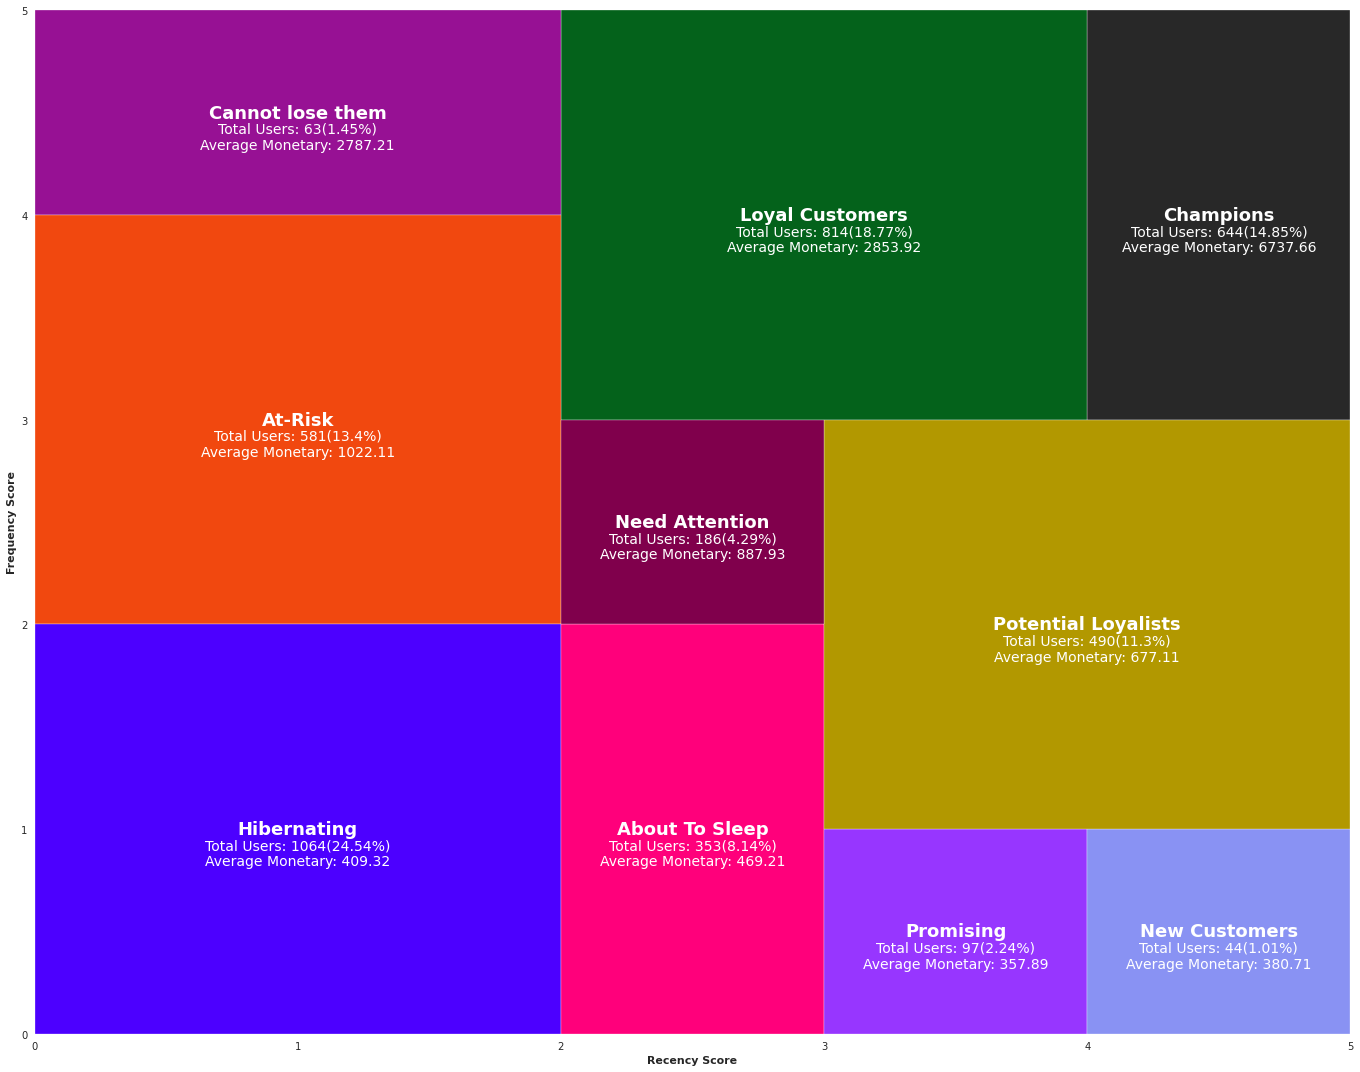

In [411]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm_table[rfm_table.Segment == key].shape[0]
    users_percentage = (rfm_table[rfm_table.Segment == key].shape[0] / rfm_table.shape[0]) * 100
    avg_monetary = rfm_table[rfm_table.Segment == key]["Monetary"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

## Visualizing RFM Segments

We can show table of descriptive statistics for RFM segments, but it is not best way. Using data visualization skills and creating great plots as important as finding great results.

In [540]:
rfm_table2 = rfm_table.reset_index()

rfm_monetary_size = rfm_table2.groupby("Segment").agg({"Monetary": "mean",
                                                       "CustomerID": "nunique"})

rfm_monetary_size.rename(columns = {"Monetary": "MeanMonetary", "CustomerID": "CustomerCount"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("MeanMonetary", ascending = False)

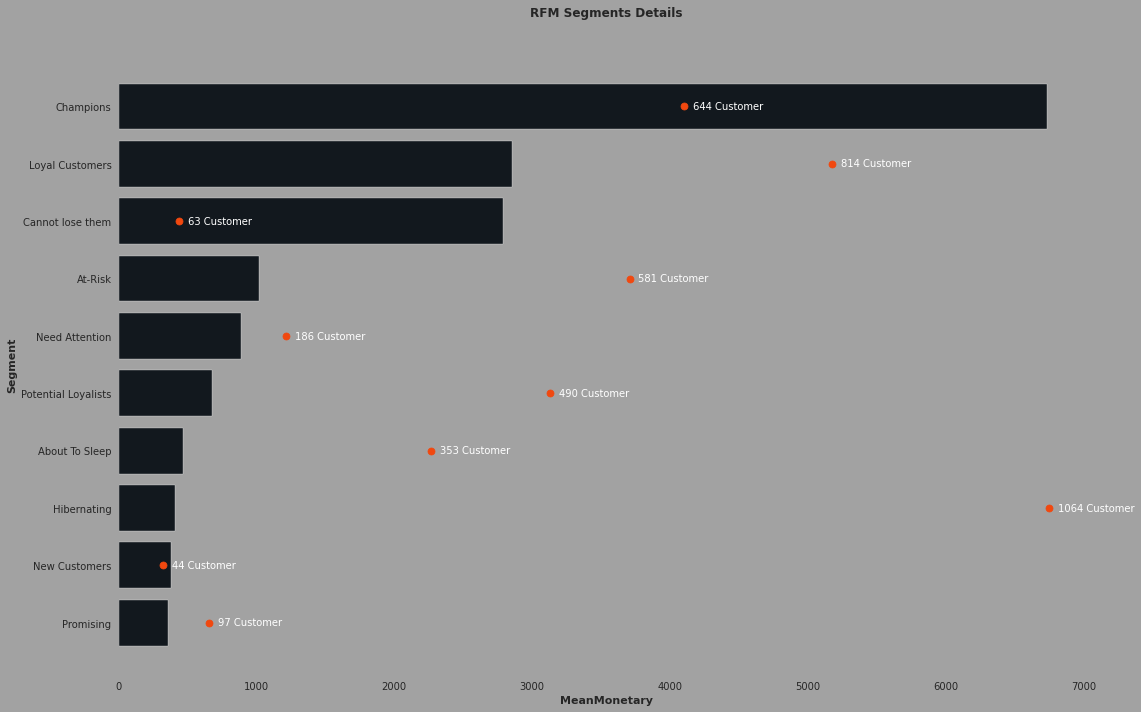

In [541]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (16, 10), facecolor = "#A2A2A2")

sns.barplot(x = rfm_monetary_size.MeanMonetary, y = rfm_monetary_size.index, ax = ax, color = "#101820")
ax2 = ax.twiny()
sns.lineplot(x = rfm_monetary_size.CustomerCount, y = rfm_monetary_size.index, ax = ax2, marker = "o", linewidth = 0,
             color = "#F1480F", markeredgecolor = "#F1480F")


ax2.axis("off")

for y, x in list(enumerate(rfm_monetary_size.CustomerCount)):
    ax2.text(x + 10, y + 0.05, str(x) + " Customer", color = "white", fontweight = "normal")

plt.title("RFM Segments Details")
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

In [542]:
rfm = rfm_table2.groupby("Segment").agg({"CustomerID": "nunique", 
                                        "Recency": "mean",
                                        "Frequency": "mean",
                                        "Monetary": "mean"})
rfm.rename(columns = {"CustomerID": "Segment Size"}, inplace = True)

cm = sns.light_palette("#A2A2A2", as_cmap = True)

rfm.T.style.background_gradient(cmap = cm, axis = 1)\
.set_precision(2)\
.highlight_min(axis = 1, color = "#195190")\
.highlight_max(axis = 1, color = "#D60000")

Segment,About To Sleep,At-Risk,Cannot lose them,Champions,Hibernating,Loyal Customers,Need Attention,New Customers,Potential Loyalists,Promising
Segment Size,353.00,581.00,63.00,644.00,1064.00,814.00,186.00,44.00,490.00,97.00
Recency,53.44,155.19,132.43,6.02,217.83,33.71,53.18,7.18,17.21,23.64
Frequency,1.16,2.86,8.38,12.31,1.10,6.46,2.32,1.00,2.01,1.00
Monetary,469.21,1022.11,2787.21,6737.66,409.32,2853.92,887.93,380.71,677.11,357.89


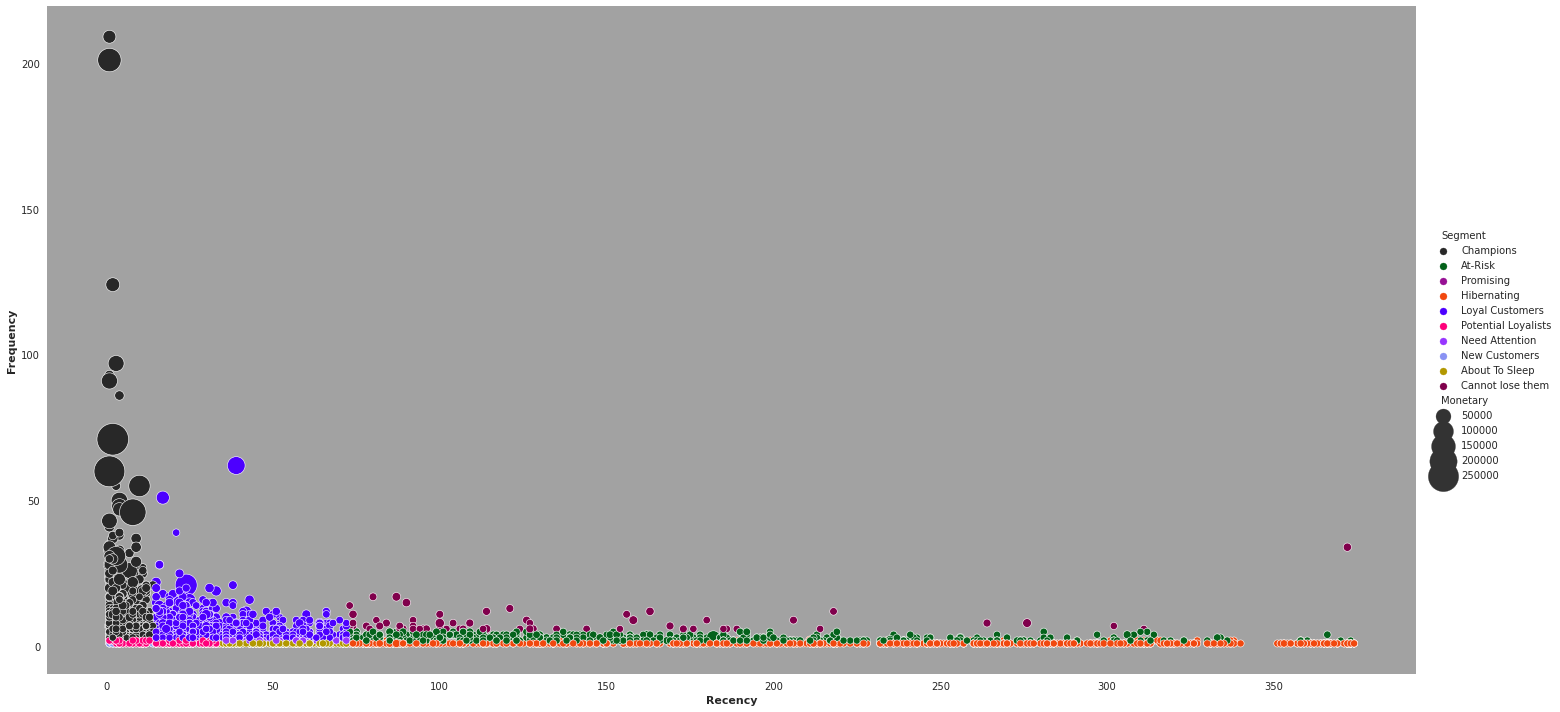

In [543]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
plt.rcParams["axes.grid"] = False

sns.relplot(x = "Recency", y = "Frequency", hue = "Segment", size = "Monetary", data = rfm_table2, palette = palette,
            height = 10, aspect = 2, sizes = (50, 1000))

plt.show()

In [544]:
monetary_per_segment = (rfm_table2.groupby("Segment")["Monetary"].sum() /\
                        rfm_table2.groupby("Segment")["Monetary"].sum().sum()).sort_values(ascending = False)

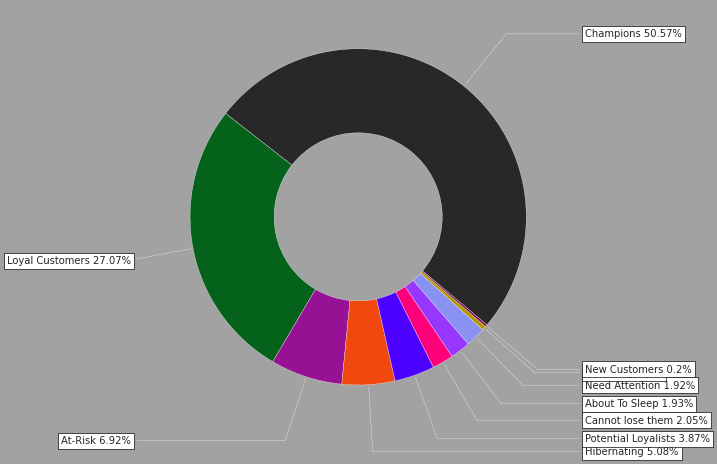

In [545]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = "#A2A2A2")

wedges, texts = ax.pie(monetary_per_segment.values, wedgeprops=dict(width=0.5), 
                       startangle=-40, colors = palette)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%", xy=(x, y), 
                xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)
plt.show()

51% of total revenue comes from "Champions" segment, and 27% of total revenue comes from "Loyal Customers" segment. These two segments have 78% of company's total revenue.

In [546]:
rfm_d = rfm_table.copy()
rfm_d.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12347.0,2,7,4310.00,5,5,5,555,15,Champions
12348.0,75,4,1797.24,2,4,4,244,10,At-Risk
12349.0,19,1,1757.55,4,1,4,414,9,Promising
12350.0,310,1,334.40,1,1,2,112,4,Hibernating
12352.0,36,8,2506.04,3,5,5,355,13,Loyal Customers


In [547]:
from sklearn.preprocessing import StandardScaler

In [548]:
rfm_clustering = rfm_table2[["Recency", "Frequency", "Monetary", "Segment"]]

for col in ["Recency", "Frequency", "Monetary"]:
    
    scaler = StandardScaler()
    rfm_clustering[col] = np.log(rfm_clustering[col])
    rfm_clustering[col] = scaler.fit_transform(rfm_clustering[col].values.reshape(-1, 1))
    
rfm_melted = pd.melt(rfm_clustering, id_vars = "Segment", value_vars = ["Recency", "Frequency", "Monetary"],
                     var_name = "RFM", value_name = "Value")

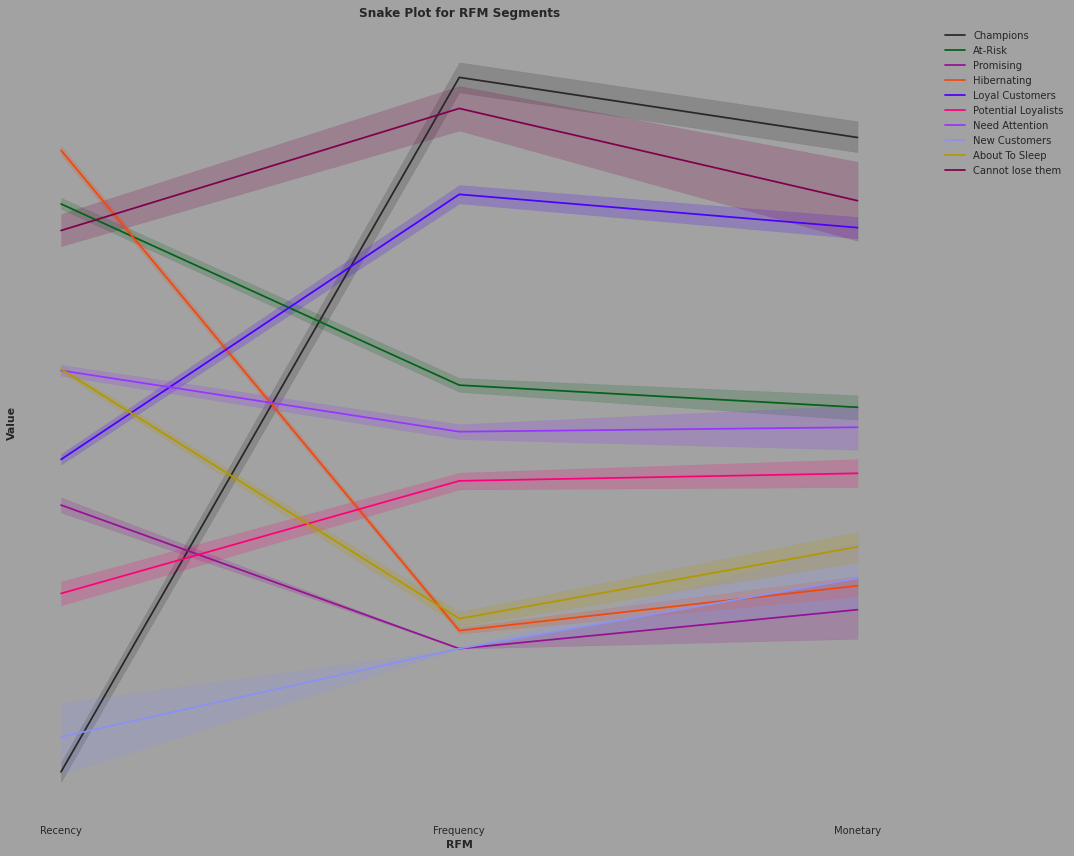

In [549]:
fig, ax = plt.subplots(figsize = (15, 12), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.lineplot(x = "RFM", y = "Value", hue = "Segment", data = rfm_melted, palette = palette)
ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
ax.set_yticks([])
ax.set_title("Snake Plot for RFM Segments")
plt.show()

In [550]:
rfm_clustering.head()

,Recency,Frequency,Monetary,Segment
0,-2.149581,1.112530,1.419579,Champions
1,0.383208,0.491467,0.723991,At-Risk
2,-0.576316,-1.047048,0.706232,Promising
3,1.374903,-1.047048,-0.613346,Hibernating
4,-0.129710,1.260724,0.988371,Loyal Customers


# 3. Customer Segmentation with using RFM Metrics

In [551]:
df_v3 =df.copy()

In [552]:
# Calculating Monetary attribute
cus_data = df.groupby('CustomerID')[['TotalPrice']].sum() # Total amount spent
cus_data.rename(columns={'TotalPrice':'Monetary'},inplace=True)
cus_data.head()

,Monetary
CustomerID,
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40
12352.0,2506.04


In [553]:
# Calculating frequency attribute
cus_data['Frequency'] = df.groupby('CustomerID')['InvoiceNo'].count()
cus_data.head()

,Monetary,Frequency
CustomerID,,
12347.0,4310.00,182
12348.0,1797.24,31
12349.0,1757.55,73
12350.0,334.40,17
12352.0,2506.04,85


In [554]:
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [555]:
df['diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDate2,diff
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12/1/2010 8:26,373 days 04:24:00
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26,373 days 04:24:00
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12/1/2010 8:26,373 days 04:24:00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26,373 days 04:24:00
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26,373 days 04:24:00


In [556]:
# Adjust today:
import datetime as dt
today = dt.datetime(2012,1,1)
# Recency and Monetary 
data_x = df.groupby('CustomerID').agg({'TotalPrice': lambda x: x.sum(),
                                        'InvoiceDate': lambda x: (today - x.max()).days})
data_x.head()

,TotalPrice,InvoiceDate
CustomerID,,
12347.0,4310.00,24
12348.0,1797.24,97
12349.0,1757.55,40
12350.0,334.40,332
12352.0,2506.04,58


In [557]:
cus_data['Recency'] = df.groupby('CustomerID')['diff'].min().dt.days
cus_data = cus_data.reset_index()
cus_data.head()

,CustomerID,Monetary,Frequency,Recency
0,12347.0,4310.00,182,1
1,12348.0,1797.24,31,74
2,12349.0,1757.55,73,18
3,12350.0,334.40,17,309
4,12352.0,2506.04,85,35


In [558]:
from datetime import datetime
def toDtObject(value):
    return datetime.strptime(value,'%m/%d/%Y %H:%M')

In [559]:
df['InvoiceDate2']=df['InvoiceDate2'].apply(toDtObject)

In [560]:
def getMonth(value):
    return int(value.strftime('%m'))
def getDay(value):
    return int(value.strftime('%d'))
def getYear(value):
    return int(value.strftime('%Y'))
def getHour(value):
    return int(value.strftime('%H'))

In [561]:
df['month']=df['InvoiceDate2'].apply(getMonth)
df['day']=df['InvoiceDate2'].apply(getDay)
df['year']=df['InvoiceDate2'].apply(getYear)
df['hour']=df['InvoiceDate2'].apply(getHour)

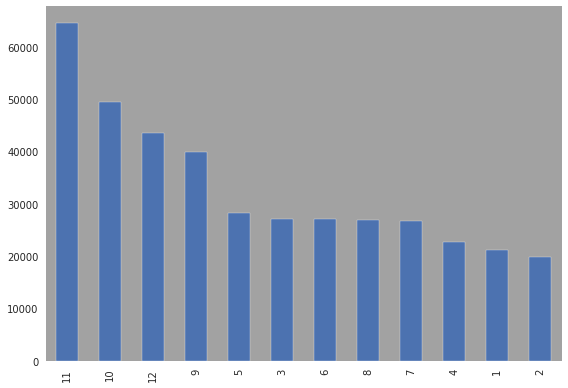

In [562]:
df.month.value_counts().plot(kind='bar')

From the above graph we can conclude that most of sales happended in the last quarter of year

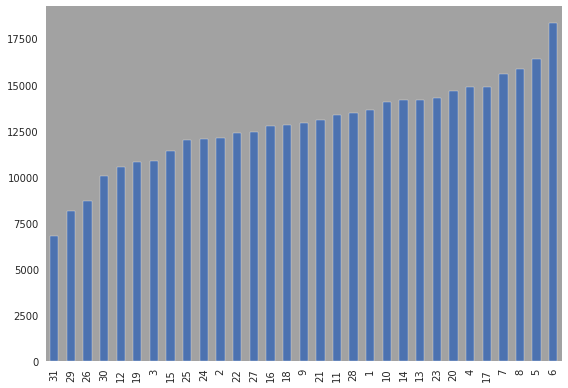

In [563]:
df.day.value_counts(ascending=True).plot(kind='bar')

In [436]:
##### Top 10 items most sales
df.Description.value_counts()[:10]

white hanging heart t-light holder    2026
regency cakestand 3 tier              1723
jumbo bag red retrospot               1618
assorted colour bird ornament         1407
party bunting                         1396
lunch bag red retrospot               1316
set of 3 cake tins pantry design      1159
lunch bag  black skull.               1105
postage                               1099
pack of 72 retrospot cake cases       1068
Name: Description, dtype: int64

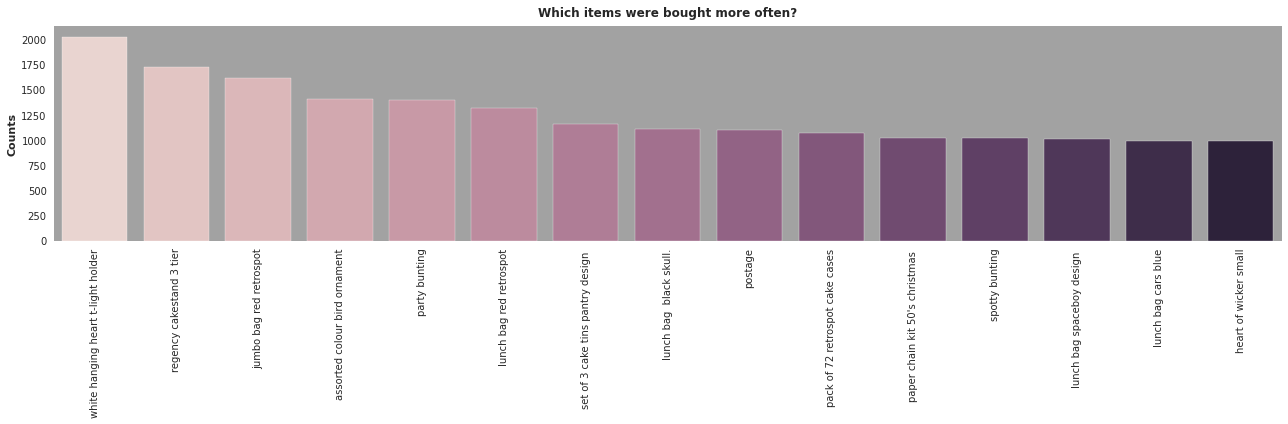

In [437]:
item_counts = df['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(item_counts.index, item_counts.values, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

In [564]:
df[df['month']==11].groupby(['Description']).sum().sort_values(by='TotalPrice',ascending=False)[:5]

,InvoiceNo,Quantity,UnitPrice,CustomerID,TotalPrice,month,day,year,hour
Description,,,,,,,,,
rabbit night light,268155754,10353,938.28,6930211.0,19617.13,5115,7204,935115,5968
paper chain kit 50's christmas,207100609,5919,1052.01,5537731.0,16139.01,3949,5928,721949,4596
white hanging heart t-light holder,137260395,4861,699.01,3680261.0,13855.83,2618,3740,478618,3010
regency cakestand 3 tier,99768635,944,2202.78,2595201.0,11064.24,1903,2691,347903,2204
jumbo bag red retrospot,122246413,5678,439.76,3272555.0,10713.99,2332,3253,426332,2656


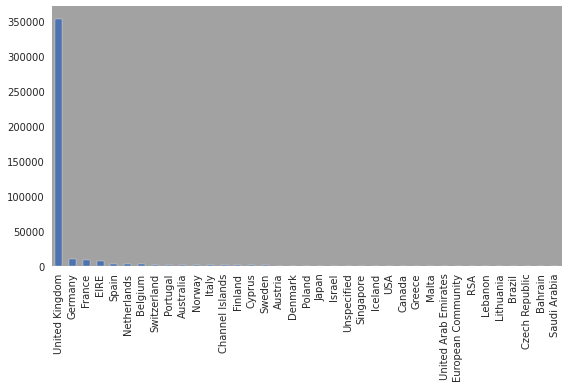

In [439]:
df.Country.value_counts().plot(kind='bar')

* United Kindom has most number of sales and remaining countries sales are very far less than it
* WHITE HANGING HEART T-LIGHT HOLDER and JUMBO BAG RED RETROSPOT product are in top positions
* Most sales happended in November month
* First week of every month has good sales count
* Huge sales are happening around 12 PM everyday
* Most sales happedned in the end of year and maybe it's because of christmas
* In those months christmas gifts related products should have more stock

In [440]:
df.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,InvoiceNo,Quantity,UnitPrice,CustomerID,TotalPrice,month,day,year,hour
0.050,538863.00,1.0,0.4200,12627.0,1.250,1.0,2.0,2010.0,9.0
0.950,579493.00,36.0,8.5000,17912.0,67.500,12.0,29.0,2011.0,17.0
0.980,580727.00,96.0,12.7500,18119.0,135.200,12.0,30.0,2011.0,17.0
0.990,581148.12,120.0,14.9500,18211.0,201.600,12.0,31.0,2011.0,19.0
0.999,581495.00,480.0,42.2972,18283.0,828.912,12.0,31.0,2011.0,20.0


(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 <a list of 11 Text major ticklabel objects>)

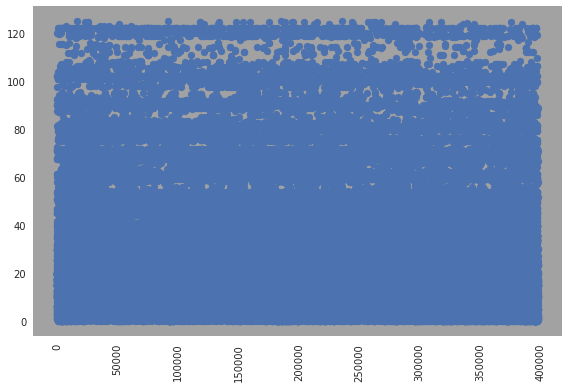

In [565]:
df_quantile = df[df['TotalPrice'] < 125]
plt.scatter(x=df_quantile.index, y=df_quantile['TotalPrice'])
plt.xticks(rotation=90)

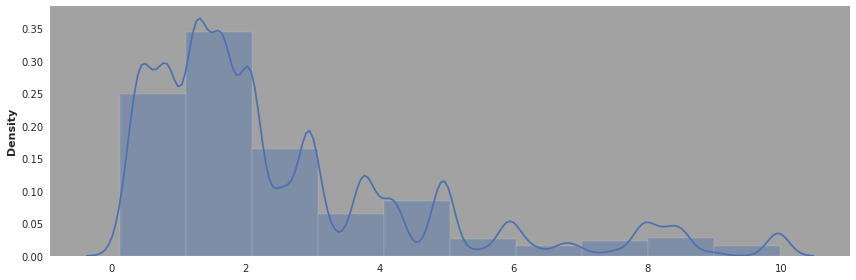

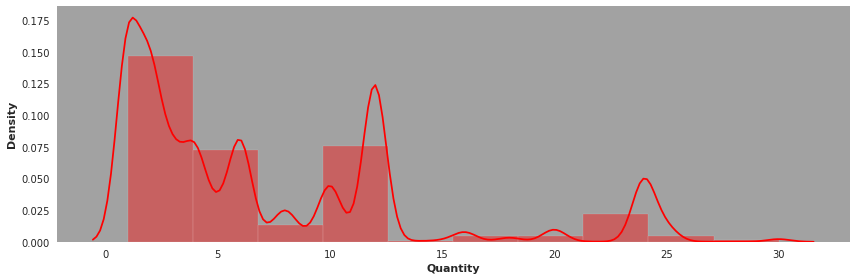

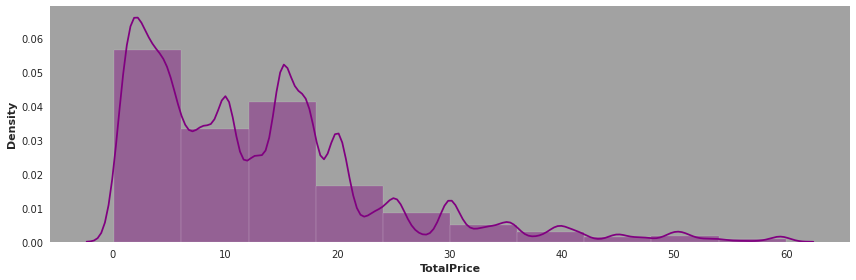

In [566]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 10]['UnitPrice'].values, kde=True, bins=10)
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 30]['Quantity'], kde=True, bins=10, color='red')
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['TotalPrice'] < 60]['TotalPrice'], kde=True, bins=10, color='purple')

- From these histograms we that people bought normally 1-5 items or 10-12 - maybe there were some kind of offers for sets?
- From these histograms we can understand that majority of 
sales per order were in range 1-15 pounds each

Treating Outliers

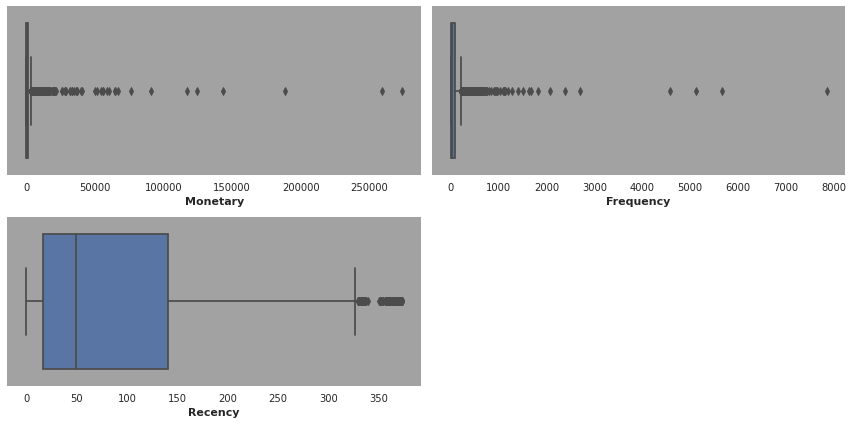

In [567]:
num_features = cus_data.columns[1:]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=cus_data,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

In [568]:
h_cap = 0.95
h_cap_val = cus_data['Monetary'].quantile(h_cap)
cus_data['Monetary'][cus_data['Monetary'] > h_cap_val] = h_cap_val
l_cap = 0.05
l_cap_val = cus_data['Monetary'].quantile(l_cap)
cus_data['Monetary'][cus_data['Monetary'] < l_cap_val] = l_cap_val
cap = 0.95
cap_val = cus_data['Frequency'].quantile(cap)
cus_data['Frequency'][cus_data['Frequency'] > cap_val] = cap_val

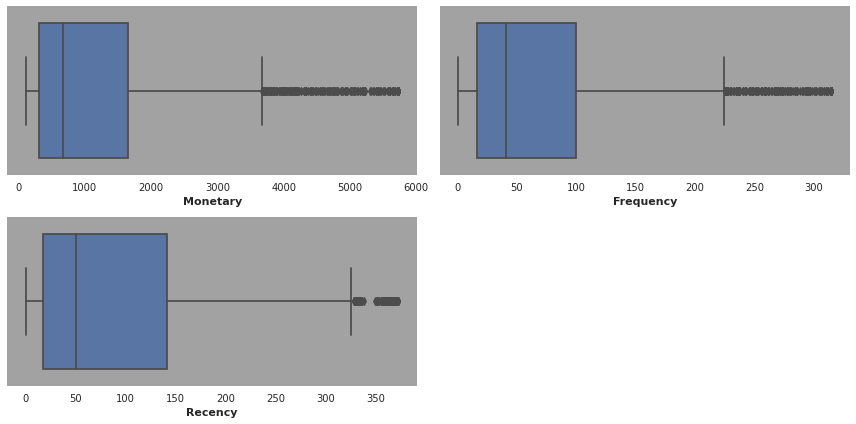

In [569]:
num_features = cus_data.columns[1:]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=cus_data,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

In [570]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

preprocessor = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("pca", PCA(n_components=2, random_state=42)),
        ]
    )

In [579]:
X = cus_data.drop('CustomerID',axis=1)
X_scaled = pd.DataFrame(preprocessor.fit_transform(X),columns=['PC_1','PC_2'])

In [580]:
X_scaled.head()

,PC_1,PC_2
0,0.661483,0.075707
1,-0.011805,-0.054133
2,0.137754,-0.148546
3,-0.493805,0.399883
4,0.223897,-0.050083


## Hopkins Test 

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [581]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [582]:
for i in range(5):
  print('Hopkins statistic value is:',round(hopkins(X_scaled),3))

Hopkins statistic value is: 0.963
Hopkins statistic value is: 0.964
Hopkins statistic value is: 0.965
Hopkins statistic value is: 0.958
Hopkins statistic value is: 0.961


*Since* the Hopkins test value hovers around 0.967, therefore given data have high clustering tendency.

## Applying k-mean

### Finding Optimal value of K (Clusters)

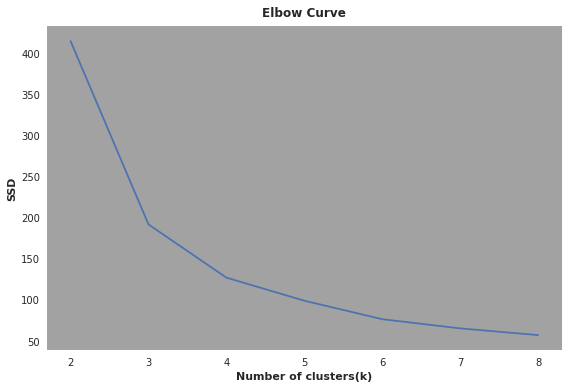

In [583]:
# elbow-curve/SSD
# k means for scaled dataset
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X_scaled)
    ssd.append(kmeans.inertia_)

plt.plot(range_n_clusters,ssd)
plt.xlabel('Number of clusters(k)')
plt.ylabel('SSD')
plt.title('Elbow Curve')
plt.show()

In [584]:
# silhouette analysis for k mean
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

For n_clusters=2, the silhouette score is 0.54
For n_clusters=3, the silhouette score is 0.55
For n_clusters=4, the silhouette score is 0.52
For n_clusters=5, the silhouette score is 0.48
For n_clusters=6, the silhouette score is 0.46
For n_clusters=7, the silhouette score is 0.43
For n_clusters=8, the silhouette score is 0.41


Using silhouette analysis k=3 seems to be the optimal number of clusters.

In [585]:
# final model with k=3
kmeans_new = KMeans(n_clusters=3, max_iter=50,random_state=1)
kmeans_new.fit(X_scaled)

KMeans(max_iter=50, n_clusters=3, random_state=1)

In [586]:
# Adding cluster labels to master dataframe
X_scaled['kmean_cluster_id'] = kmeans_new.labels_
X['kmean_cluster_id'] = kmeans_new.labels_
X.head(4)

,Monetary,Frequency,Recency,kmean_cluster_id
0,4310.00,182.0,1,1
1,1797.24,31.0,74,0
2,1757.55,73.0,18,0
3,334.40,17.0,309,2


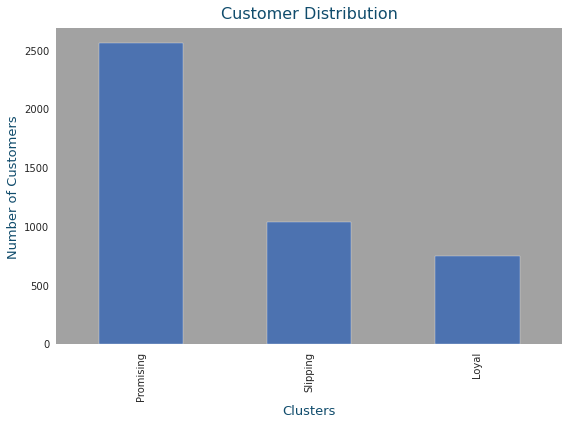

In [587]:
# Number of customers per cluster
font_title = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 16,
        }


font_label = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 13,
        }
plt.figure(figsize=(8,6))
ax = X_scaled['kmean_cluster_id'].value_counts().plot(kind='bar')
ax.set_xticklabels(['Promising','Slipping','Loyal'])
ax.set_ylabel('Number of Customers',font_label)
ax.set_xlabel('Clusters',font_label)
ax.set_title("Customer Distribution",font_title)
plt.show()

In [588]:
fig = plt.figure(figsize=[15,7])
fig = px.scatter_3d(X, x = 'Monetary', y='Frequency', z='Recency',
              color='kmean_cluster_id', opacity = 0.8,size_max=30)
fig.show()

<Figure size 1080x504 with 0 Axes>

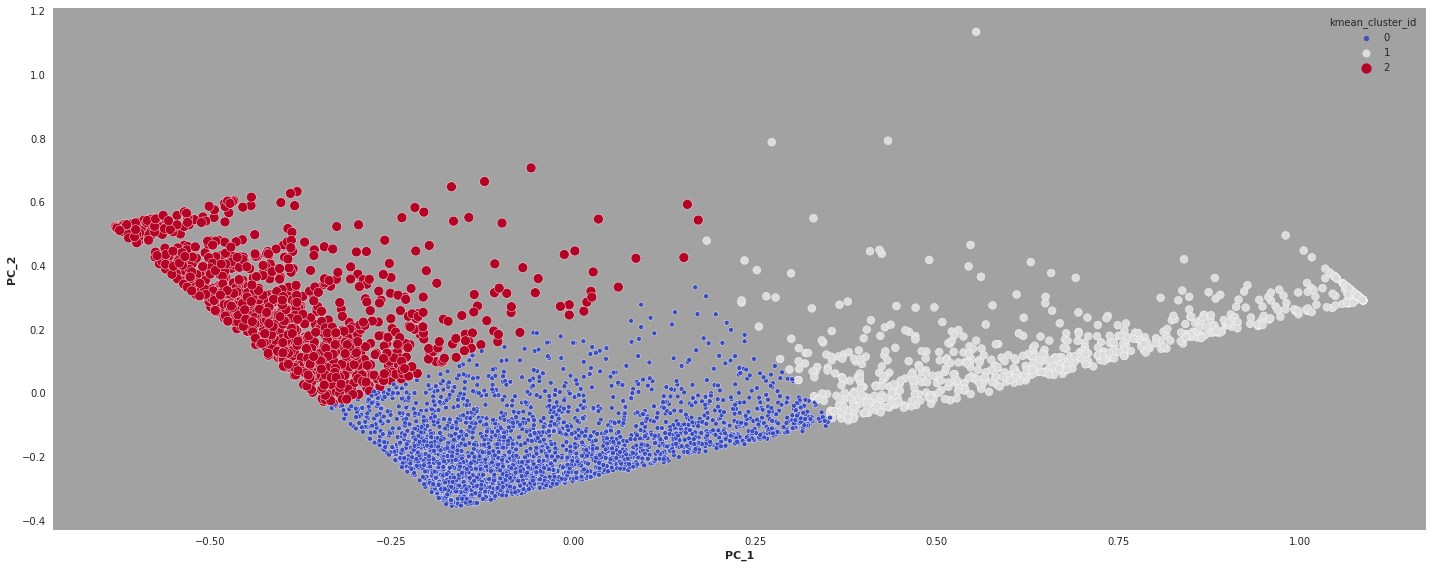

In [590]:
# Vusializing clusters using Principle Components
fig = plt.figure(figsize=[20,8])
sns.scatterplot(data=X_scaled,x="PC_1",y="PC_2",hue="kmean_cluster_id",size="kmean_cluster_id",palette="coolwarm")
plt.show()

## Applying MiniBatchKMeans

In [591]:
from sklearn.cluster import MiniBatchKMeans

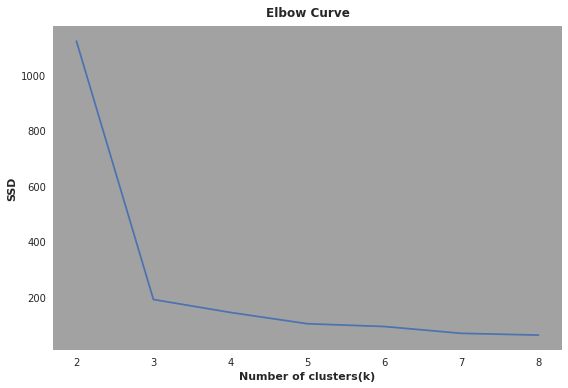

In [600]:
# elbow-curve/SSD
# k means for scaled dataset
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    MBKmeans = MiniBatchKMeans(n_clusters=num_clusters, max_iter=50)
    MBKmeans.fit(X_scaled)
    ssd.append(MBKmeans.inertia_)

plt.plot(range_n_clusters,ssd)
plt.xlabel('Number of clusters(k)')
plt.ylabel('SSD')
plt.title('Elbow Curve')
plt.show()

In [602]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    minibatchKmn = MiniBatchKMeans(n_clusters=num_clusters, max_iter=50)
    minibatchKmn.fit(X_scaled)
    
    cluster_labels = minibatchKmn.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

For n_clusters=2, the silhouette score is 0.71
For n_clusters=3, the silhouette score is 0.81
For n_clusters=4, the silhouette score is 0.6
For n_clusters=5, the silhouette score is 0.57
For n_clusters=6, the silhouette score is 0.49
For n_clusters=7, the silhouette score is 0.48
For n_clusters=8, the silhouette score is 0.43


for MiniBatchKmean, We can see that k=3 seems to be the optimal number of clusters. Also, its score is high than kmean

In [603]:
# final model with k=3
mbkmeans_new = MiniBatchKMeans(n_clusters=3, max_iter=50,random_state=1)
mbkmeans_new.fit(X_scaled)

MiniBatchKMeans(max_iter=50, n_clusters=3, random_state=1)

In [604]:
# Adding cluster labels to master dataframe
X_scaled['MiniBatch_cluster'] = mbkmeans_new.labels_
X['MiniBatch_cluster'] = mbkmeans_new.labels_
X.head(4)

,Monetary,Frequency,Recency,kmean_cluster_id,MiniBatch_cluster
0,4310.00,182.0,1,1,2
1,1797.24,31.0,74,0,0
2,1757.55,73.0,18,0,0
3,334.40,17.0,309,2,1


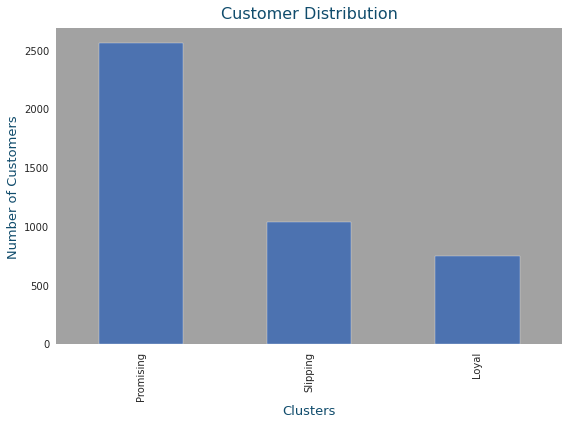

In [605]:
# Number of customers per cluster
font_title = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 16,
        }


font_label = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 13,
        }
plt.figure(figsize=(8,6))
ax = X_scaled['MiniBatch_cluster'].value_counts().plot(kind='bar')
ax.set_xticklabels(['Promising','Slipping','Loyal'])
ax.set_ylabel('Number of Customers',font_label)
ax.set_xlabel('Clusters',font_label)
ax.set_title("Customer Distribution",font_title)
plt.show()


## Inference:

* Cluster 0 contains the customers who generate the least revenue and are not frequent, most likely because these were one-time customers. Hence they can be labeled as Slipping.
* Cluster 1 seems to have the most loyal customers, as they bring the most revenue and are often the most frequent customers.
* Cluster 2 customers seem promising as it consists of frequent buyers, however revenue generation is not as high as Loyal customers

## Recommendations

* After segmenting customers into loyal, slipping, and promising it empowers businesses to run personalized, high-performing campaigns and preserves profit margin. Below are a few recommendations or targeted strategies for each customer segment:

* Loyal - Loyalty programs are effective for these repeat visitors. Advocacy programs and reviews are also common X1X strategies. Lastly, consider rewarding these customers with Free Shipping or other like benefits.

* Promising - Focus on increasing monetization through product recommendations based on past purchases and incentives tied to spending thresholds.

* Slipping - Customers leave for a variety of reasons. Depending on your situation price deals, new product launches, or other retention strategies.

# Customer Segmentation without rfm values

In [606]:
df_v3.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDate2
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12/1/2010 8:26
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12/1/2010 8:26
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12/1/2010 8:26


In [607]:
df_v3.drop('InvoiceDate2', axis=1, inplace=True)

In [608]:
df_v3.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [609]:
#For clustering, we need to drop the rows with no product code (Amazon fee, postage, bank charges, and others). 
df_products=df_v3[df_v3['StockCode'].str.contains('^[1-9]')]
df_products.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [610]:
df_products.rename(columns={'TotalPrice': 'Total_Revenue'}, inplace=True)
df_products.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Revenue
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [611]:
#let's try some SQL code to see how it works in python
!pip install pandasql
from pandasql import sqldf

In [612]:
#let's group the purchases by customer
df_sales=sqldf("SELECT CustomerID, COUNTRY, COUNT(InvoiceNo) AS Total_purchases, SUM(Total_Revenue) as Total_Revenue, SUM(Quantity) as Quantity FROM df_products GROUP BY CustomerID ORDER BY Quantity desc;")
df_sales.head()

,CustomerID,Country,Total_purchases,Total_Revenue,Quantity
0,14646.0,Netherlands,2058,272901.86,192716
1,14911.0,EIRE,5579,136235.30,79466
2,12415.0,Australia,713,124564.53,77373
3,17450.0,United Kingdom,334,188323.51,64227
4,18102.0,United Kingdom,431,259657.30,64124


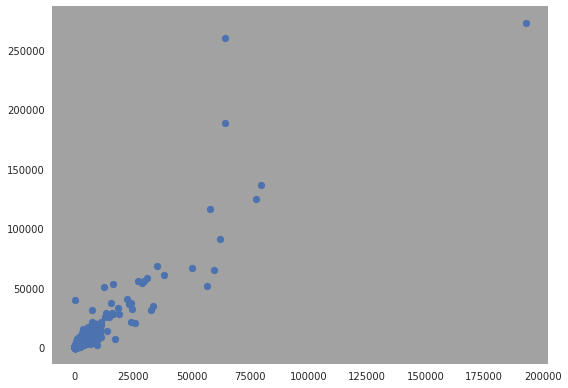

In [613]:
#now, let's see how the data is distributed
plt.scatter(df_sales['Quantity'], df_sales['Total_Revenue'])

Text(0.5, 1.0, 'Quantity vs Revenue per client')

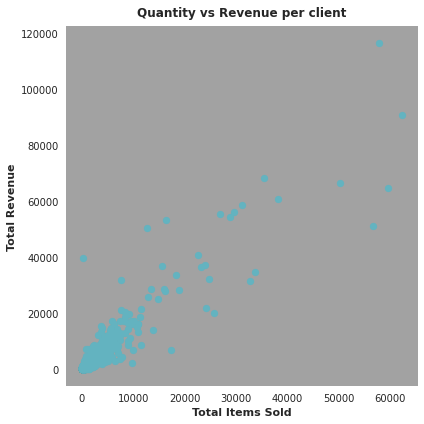

In [614]:
#Here we can see outliers, to better indentify the cluster centers, we need to set limits to the top values of Total_revenue and Quantity
df_clustering=sqldf("SELECT CustomerID,	Total_purchases,	Total_Revenue,	Quantity FROM df_sales WHERE Total_Revenue <150000 and Quantity <70000")
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(df_clustering['Quantity'], df_clustering['Total_Revenue'], color=('#63b3c0'))
plt.xlabel('Total Items Sold')
plt.ylabel('Total Revenue')
plt.title('Quantity vs Revenue per client')

## Scaling using minmax scaler


In [615]:
scaler=MinMaxScaler()
scaler.fit(df_clustering[['Quantity']])
df_clustering['Quantity_scaled']=scaler.transform(df_clustering[['Quantity']])

scaler.fit(df_clustering[['Total_Revenue']])
df_clustering['Revenue_scaled']=scaler.transform(df_clustering[['Total_Revenue']])
df_clustering.head()

,CustomerID,Total_purchases,Total_Revenue,Quantity,Quantity_scaled,Revenue_scaled
0,17511.0,957,90831.98,62245,1.000000,0.778161
1,13694.0,564,64815.62,59612,0.957699,0.555271
2,14156.0,1386,116725.63,57772,0.928138,1.000000
3,14298.0,1627,51415.70,56757,0.911831,0.440469
4,16684.0,277,66653.56,50255,0.807371,0.571017


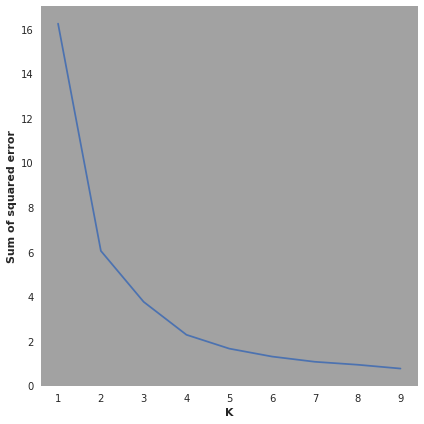

In [616]:
#Now we need to find the k-clusters. Let's use the Elbow method to find them
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df_clustering[['Quantity_scaled','Revenue_scaled']])
    sse.append(km.inertia_)

fig, axes = plt.subplots(1,1,figsize=(6,6))
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [617]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_clustering[['Quantity_scaled','Revenue_scaled']])
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_clustering[['Quantity_scaled','Revenue_scaled']], cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

For n_clusters=2, the silhouette score is 0.96
For n_clusters=3, the silhouette score is 0.85
For n_clusters=4, the silhouette score is 0.8
For n_clusters=5, the silhouette score is 0.71
For n_clusters=6, the silhouette score is 0.71
For n_clusters=7, the silhouette score is 0.64
For n_clusters=8, the silhouette score is 0.64


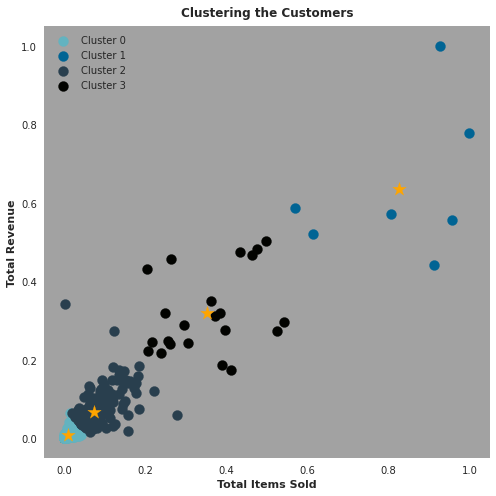

In [618]:
#Let's trye Kmean method with the scaled data
km=KMeans(n_clusters=4)
points=df_clustering[['Quantity_scaled','Revenue_scaled']].to_numpy()
y_km=km.fit_predict(points)

fig, axes = plt.subplots(1,1,figsize=(7,7))
Cluster_0=plt.scatter(points[y_km ==0,0], points[y_km == 0,1], s=100, c='#63b3c0')
Cluster_1=plt.scatter(points[y_km ==1,0], points[y_km == 1,1], s=100, c='#006494')
Cluster_2=plt.scatter(points[y_km ==2,0], points[y_km == 2,1], s=100, c='#293f4e')
Cluster_3=plt.scatter(points[y_km ==3,0], points[y_km == 3,1], s=100, c='#020300')


plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='orange',marker='*',label='centroid',s=200)
plt.xlabel('Total Items Sold')
plt.ylabel('Total Revenue')
plt.title('Clustering the Customers')
plt.legend([Cluster_0,Cluster_1,Cluster_2,Cluster_3],['Cluster 0','Cluster 1','Cluster 2','Cluster 3'])

### AgglomerativeClustering

Text(0.5, 1.0, 'Clustering the Customers')

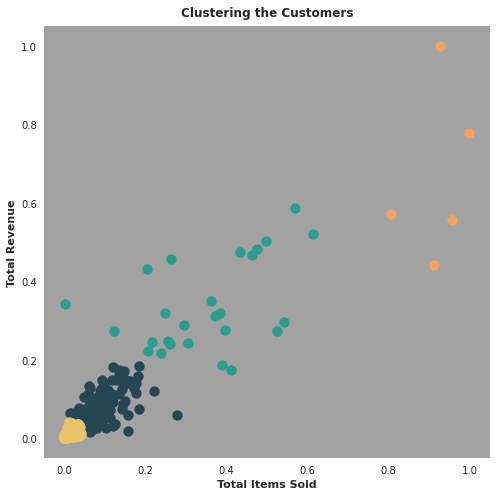

In [619]:
#Agglomerative Cluster
agg = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
y_agg = agg.fit_predict(points)

fig, axes = plt.subplots(1,1,figsize=(7,7))
plt.scatter(points[y_agg ==0,0], points[y_agg == 0,1], s=100, c='#264653')
plt.scatter(points[y_agg ==1,0], points[y_agg == 1,1], s=100, c='#2a9d8f')
plt.scatter(points[y_agg ==2,0], points[y_agg == 2,1], s=100, c='#e9c46a')
plt.scatter(points[y_agg ==3,0], points[y_agg == 3,1], s=100, c='#f4a261')

plt.xlabel('Total Items Sold')
plt.ylabel('Total Revenue')
plt.title('Clustering the Customers')

In [620]:
df_clustering["cluster_agg"] = agg.labels_
df_clustering["cluster_km"] = km.labels_
df_clustering.head(10)

,CustomerID,Total_purchases,Total_Revenue,Quantity,Quantity_scaled,Revenue_scaled,cluster_agg,cluster_km
0,17511.0,957,90831.98,62245,1.000000,0.778161,3,1
1,13694.0,564,64815.62,59612,0.957699,0.555271,3,1
2,14156.0,1386,116725.63,57772,0.928138,1.000000,3,1
3,14298.0,1627,51415.70,56757,0.911831,0.440469,3,1
4,16684.0,277,66653.56,50255,0.807371,0.571017,3,1
5,15311.0,2379,60767.90,38194,0.613601,0.520593,1,1
6,16029.0,239,68370.09,35407,0.568826,0.585723,1,1
7,16422.0,369,34684.40,33704,0.541466,0.297127,1,3
8,17404.0,195,31781.82,32744,0.526043,0.272260,1,3
9,13089.0,1818,58825.83,31070,0.499149,0.503954,1,3


## DBSCAN clustering

In [621]:
from sklearn.cluster import DBSCAN

Text(0.5, 1.0, 'DBSCAN')

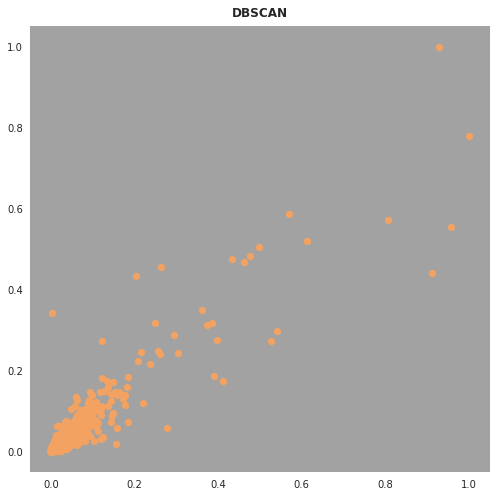

In [622]:
#let's import a third method: DBSCAN

db = DBSCAN(eps=0.08,min_samples=4)
db.fit(points)
f, axis=plt.subplots(1,1,figsize=(7,7))
y_pred = db.fit_predict(points)
plt.scatter(points[:,0], points[:,1],c='#f4a261')
plt.title("DBSCAN")


DBSCAN algorithm did not work very well this time due to the diferent density of each cluster

The e-commerce sales EDA showed as some interesting facts about the sales and the products. And the clustering helped us to identify the segmnets of customers we have in our ecommerce.